In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from sklearn.preprocessing import MinMaxScaler
import os
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# 强制使用 Arial 字体（前提是系统已安装）
plt.rcParams["font.family"] = "Arial"

def truncate_colormap(cmap, minval=0.2, maxval=1.0, n=256):
    new_cmap = LinearSegmentedColormap.from_list(
        f"trunc({cmap.name},{minval:.2f},{maxval:.2f})",
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def process_file(file_path, target_pH=7.0):
    if file_path.endswith(".csv"):
        df = pd.read_csv(file_path)
    elif file_path.endswith(".xlsx"):
        df = pd.read_excel(file_path)
    else:
        raise ValueError("Unsupported file format: " + file_path)

    if "step" not in df.columns or df["step"].isnull().all():
        df.insert(0, "step", np.arange(1, len(df) + 1))

    step0 = {
        "step": 0,
        "reagent": "none",
        "volume": 0.0,
        "pH_before": df.loc[0, "pH_before"],
        "pH_after": df.loc[0, "pH_before"],
        "pH_change": 0.0
    }
    df = pd.concat([pd.DataFrame([step0]), df], ignore_index=True)
    df["delta_from_target"] = df["pH_after"] - target_pH
    return df

def plot_multiple_ph_charts(file_list, target_pH=7.0, save_path=".", filename="multi_ph_deviation.svg", ncols=2):
    dfs = [process_file(f, target_pH) for f in file_list]
    n = len(dfs)
    nrows = int(np.ceil(n / ncols))

    all_acid_vol = []
    all_base_vol = []
    for df in dfs:
        all_acid_vol += df[df["reagent"] == "acid"]["volume"].tolist()
        all_base_vol += df[df["reagent"] == "base"]["volume"].tolist()

    acid_norm = mcolors.Normalize(vmin=min(all_acid_vol), vmax=max(all_acid_vol)) if all_acid_vol else None
    base_norm = mcolors.Normalize(vmin=min(all_base_vol), vmax=max(all_base_vol)) if all_base_vol else None

    acid_cmap = truncate_colormap(cm.get_cmap("Reds"), 0.2, 1.0)
    base_cmap = truncate_colormap(cm.get_cmap("Blues"), 0.2, 1.0)
    neutral_color = "#AAAAAA"

    fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4.2 * nrows), squeeze=False)
    axes = axes.flatten()

    for i, (df, ax) in enumerate(zip(dfs, axes)):
        steps = df["step"].astype(int)
        colors = []
        for _, row in df.iterrows():
            if row["reagent"] == "acid":
                colors.append(acid_cmap(acid_norm(row["volume"])) if acid_norm else neutral_color)
            elif row["reagent"] == "base":
                colors.append(base_cmap(base_norm(row["volume"])) if base_norm else neutral_color)
            else:
                colors.append(neutral_color)

        ax.bar(steps, df["delta_from_target"], color=colors, edgecolor='black', width=0.6)
        ax.axhline(0, color="gray", linestyle="--", linewidth=1)

        ax.set_xticks(steps)
        ax.set_xticklabels(steps, fontsize=12)
        ax.tick_params(axis='y', labelsize=12)
        title = os.path.splitext(os.path.basename(file_list[i]))[0]
        ax.set_title(title, fontsize=14)
        ax.set_xlabel("Step", fontsize=14)
        ax.set_ylabel("pH – Target", fontsize=14)
        ax.grid(False)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    if acid_norm:
        sm_acid = cm.ScalarMappable(cmap=acid_cmap, norm=acid_norm)
        cbar_a = fig.colorbar(sm_acid, ax=axes.tolist(), orientation="vertical", fraction=0.015, pad=0.01)
        cbar_a.set_label("Acid Volume (mL)", fontsize=12)

    if base_norm:
        sm_base = cm.ScalarMappable(cmap=base_cmap, norm=base_norm)
        cbar_b = fig.colorbar(sm_base, ax=axes.tolist(), orientation="vertical", fraction=0.015, pad=0.04)
        cbar_b.set_label("Base Volume (mL)", fontsize=12)

    plt.tight_layout()
    os.makedirs(save_path, exist_ok=True)
    full_path = os.path.join(save_path, filename)
    plt.savefig(full_path, format="svg")
    print(f"Saved multi-figure chart to {full_path}")


In [4]:
print(plt.rcParams["font.family"])


['Arial']


In [2]:
"""
ph_dualaxis_plot_plasma.py
--------------------------
• 读取 1 ~ N 个 CSV / XLSX（列：reagent, volume, pH_before, pH_after）
• 数据单位默认为 **mL** （无需再 ÷1000）
• 左轴：体积柱
      – Acid  : 实心渐变填充，边框比填充再深 20 %
      – Base  : 透明柱 + 彩色斜线，边框同色
• 右轴：黑色 “X” = pH_after；灰虚线 = target pH
• 统一 plasma_trunc 色条（15 %→100 %，避免白）
• 图例使用色条最深色
"""

from __future__ import annotations
import os
from typing import List
from matplotlib.lines import Line2D      # ← 在 import 区域加这一行

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap, to_rgba
from matplotlib.patches import Rectangle, Patch
from mpl_toolkits.axes_grid1 import make_axes_locatable


def _darken_rgba(rgba: tuple[float, float, float, float],
                 factor: float = 1.3) -> tuple[float, float, float, float]:
    r, g, b, a = rgba
    return (min(r * factor, 1.0),
            min(g * factor, 1.0),
            min(b * factor, 1.0),
            a)


def _read_file(path: str) -> pd.DataFrame:
    if path.lower().endswith(".csv"):
        df = pd.read_csv(path)
    elif path.lower().endswith((".xls", ".xlsx")):
        df = pd.read_excel(path)
    else:
        raise ValueError(f"Unsupported file extension: {path}")

    if "step" not in df.columns or df["step"].isnull().any():
        df.insert(0, "step", np.arange(1, len(df) + 1, dtype=int))
    df["step"] = df["step"].astype(int)

    # prepend step-0
    step0 = dict(step=0,
                 reagent="none",
                 volume=0.0,
                 pH_before=df.loc[0, "pH_before"],
                 pH_after=df.loc[0, "pH_before"],
                 pH_change=0.0)
    return pd.concat([pd.DataFrame([step0]), df], ignore_index=True)


def plot_ph_files(files: List[str],
                  target_pH: float = 7.0,
                  ncols: int = 2,
                  figsize_per_subplot: tuple[float, float] = (5.0, 4.0),
                  save_path: str | None = None,
                  filename: str = "ph_multi.svg") -> None:
    """Plot one or more stepwise pH-adjustment files in a grid."""

    dfs = [_read_file(f) for f in files]

    # ---------- colormap & normalisation ---------------------------------
    plasma_orig = cm.get_cmap("GnBu")
    custom_cmap = LinearSegmentedColormap.from_list(
        "plasma_trunc", plasma_orig(np.linspace(0.15, 1, 256))
    )

    all_vols = pd.concat([df["volume"] for df in dfs])
    vol_norm = mcolors.Normalize(vmin=all_vols.min(), vmax=all_vols.max())

    # ---------- figure grid ----------------------------------------------
    nplots = len(dfs)
    nrows = int(np.ceil(nplots / ncols))
    fig_w = figsize_per_subplot[0] * ncols
    fig_h = figsize_per_subplot[1] * nrows
    fig, axes = plt.subplots(nrows, ncols,
                             figsize=(fig_w, fig_h), squeeze=False)
    axes_flat = axes.flatten()

    for ax, df, path in zip(axes_flat, dfs, files):
        steps   = df["step"]
        volumes = df["volume"]
        pH_aft  = df["pH_after"]

        base_cols = [custom_cmap(vol_norm(v)) if r != "none"
                     else (0.8, 0.8, 0.8, 1.0)
                     for v, r in zip(volumes, df["reagent"])]

        for st, vol, fill_c, reagent in zip(steps, volumes, base_cols,
                                            df["reagent"]):
            # 边框颜色 = 色条上再向深端推进 0.2（最多 1.0）
            edge_val = min(vol_norm(vol) + 0.20, 1.0)
            edge_c   = custom_cmap(edge_val)

            if reagent == "acid":
                ax.bar(st, vol,
                       color=fill_c,
                       edgecolor=edge_c,
                       width=0.6,
                       linewidth=2.0,
                       zorder=3)
            elif reagent == "base":
                ax.add_patch(
                    Rectangle((st - 0.3, 0), 0.6, vol,
                              facecolor="none",
                              edgecolor=edge_c,
                              linewidth=2.0,
                              hatch="//////",
                              zorder=3)
                )
                ax.bar(st, vol, color=fill_c,
                       edgecolor=edge_c,
                       width=0.6, alpha=0.0)   # invisible fill

        # ---------- right axis pH ----------------------------------------
        ax2 = ax.twinx()
        ax2.plot(steps, pH_aft,
                 marker="x", linestyle="None",
                 color="#FF7070", markersize=5, zorder=4)
        ax2.axhline(target_pH, color="gray",
                    linestyle="--", linewidth=1.2, zorder=2)

        # ---------- axis cosmetics ---------------------------------------
        title_txt = os.path.splitext(os.path.basename(path))[0]
        ax.set_title(title_txt, fontsize=12, fontfamily="Arial")
        ax.set_xlabel("Step", fontsize=11, fontfamily="Arial")
        ax.set_ylabel("Volume added (mL)", fontsize=11, fontfamily="Arial")
        ax2.set_ylabel("pH", fontsize=11, fontfamily="Arial")

        ax.set_xticks(steps)
        ax.tick_params(labelsize=9)
        ax2.tick_params(labelsize=9)
        ax.set_ylim(bottom=0)
        ax.grid(False)
        ax2.grid(False)

    # remove empty subplots
    for extra_ax in axes_flat[nplots:]:
        extra_ax.remove()

    # ---------- shared colour-bar ----------------------------------------
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cb = plt.colorbar(cm.ScalarMappable(norm=vol_norm, cmap=custom_cmap),
                      cax=cbar_ax)
    cb.set_label("Volume (mL)", fontsize=11, fontfamily="Arial")

    # ---------- legend ----------------------------------------------------
# ---------- legend ----------------------------------------------------
    deep_col = custom_cmap(1.0)

    legend_elems = [
        Patch(facecolor=deep_col, edgecolor=deep_col,
            label="Acid", linewidth=2.0),                         # 实心柱
        Patch(facecolor="none", edgecolor=deep_col,                 # 斜线柱
            hatch="//////", label="Base", linewidth=2.0),
        Line2D([0], [0], marker="x", linestyle="None",              # pH 点 (圆点示例)
            markerfacecolor="#FF7070", markeredgecolor="#FF7070",
            markersize=7, label="pH after")                      # 若仍用 "x"，改 marker="x"
    ]

    axes_flat[0].legend(handles=legend_elems,
                        loc="upper left", fontsize=10)


    # save or show
    if save_path:
        os.makedirs(save_path, exist_ok=True)
        out = os.path.join(save_path, filename)
        fig.savefig(out, dpi=300, bbox_inches="tight")
        print(f"Saved: {out}")
    else:
        plt.show()


# --------------------------- quick demo --------------------------------------



C:\Users\ZSY\AppData\Local\Temp\ipykernel_23156\3255844945.py:71: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plasma_orig = cm.get_cmap("GnBu")


Saved: C:\Users\ZSY\Desktop\画图3\上传\ph_multi_plasma.svg


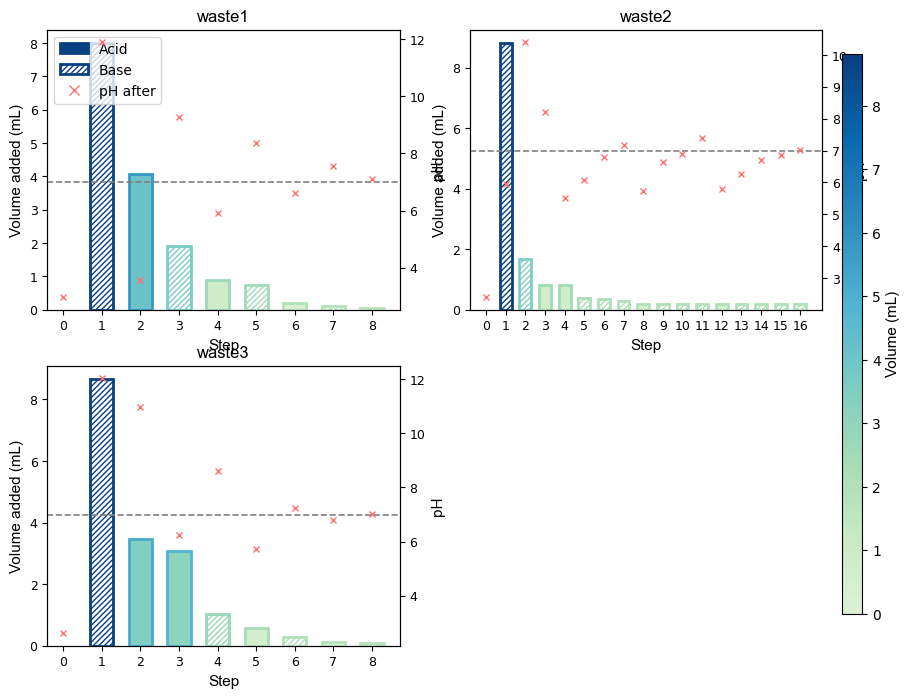

In [ ]:
if __name__ == "__main__":
    # Example: replace with your own files
    plot_ph_files(
           files = [
    r"C:\Users\ZSY\Desktop\code\ph\写文章\数据\废水\waste1.xlsx",
    r"C:\Users\ZSY\Desktop\code\ph\写文章\数据\废水\waste2.xlsx",
    r"C:\Users\ZSY\Desktop\code\ph\写文章\数据\废水\waste3.xlsx"
],
        target_pH=7.0,
        ncols=2,
        save_path="figures",
        filename=r"C:\Users\ZSY\Desktop\画图3\上传\ph_multi_plasma.svg"
    )

C:\Users\ZSY\AppData\Local\Temp\ipykernel_23156\1707238793.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plasma_orig = cm.get_cmap("GnBu")


Saved: figures\ph_multi_plasma.svg


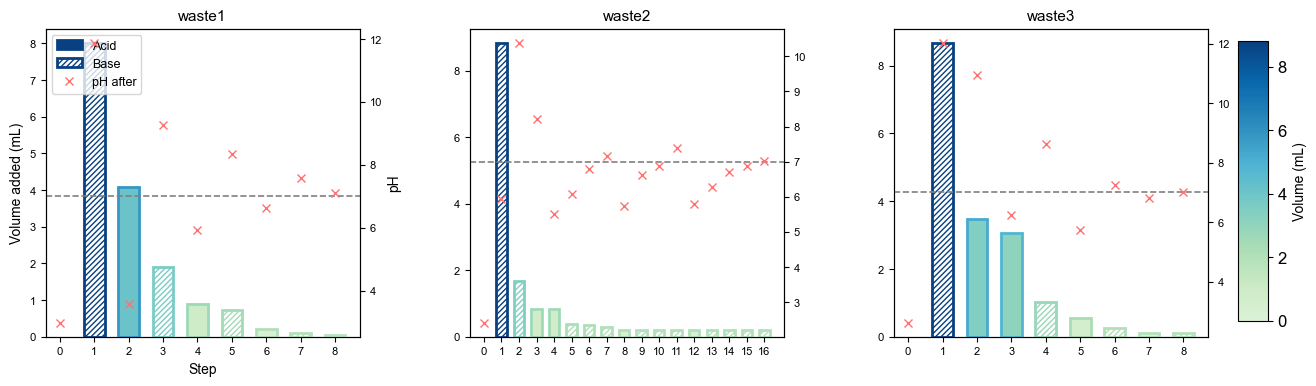

In [ ]:
from __future__ import annotations
import os
from typing import List
from matplotlib.lines import Line2D

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle, Patch
from mpl_toolkits.axes_grid1 import make_axes_locatable


# ---------------------- 之前已有的辅助函数 ----------------------
def _darken_rgba(rgba: tuple[float, float, float, float],
                 factor: float = 1.3) -> tuple[float, float, float, float]:
    r, g, b, a = rgba
    return (min(r * factor, 1.0),
            min(g * factor, 1.0),
            min(b * factor, 1.0),
            a)


def _read_file(path: str) -> pd.DataFrame:
    if path.lower().endswith(".csv"):
        df = pd.read_csv(path)
    elif path.lower().endswith((".xls", ".xlsx")):
        df = pd.read_excel(path)
    else:
        raise ValueError(f"Unsupported file extension: {path}")

    if "step" not in df.columns or df["step"].isnull().any():
        df.insert(0, "step", np.arange(1, len(df) + 1, dtype=int))
    df["step"] = df["step"].astype(int)

    # prepend step-0
    step0 = dict(step=0,
                 reagent="none",
                 volume=0.0,
                 pH_before=df.loc[0, "pH_before"],
                 pH_after=df.loc[0, "pH_before"],
                 pH_change=0.0)
    return pd.concat([pd.DataFrame([step0]), df], ignore_index=True)


# ---------------------- 主函数（已修改） ----------------------
def plot_ph_files(files: List[str],
                  target_pH: float = 7.0,
                  ncols: int = 3,                          # ← 默认 3 列
                  figsize_per_subplot: tuple[float, float] = (5.0, 4.0),
                  save_path: str | None = None,
                  filename: str = "ph_multi.svg") -> None:
    """Plot one or more step-wise pH-adjustment files in a grid."""

    dfs = [_read_file(f) for f in files]

    # ---------- colormap & normalisation ----------
    plasma_orig = cm.get_cmap("GnBu")
    custom_cmap = LinearSegmentedColormap.from_list(
        "plasma_trunc", plasma_orig(np.linspace(0.15, 1, 256))
    )

    all_vols = pd.concat([df["volume"] for df in dfs])
    vol_norm = mcolors.Normalize(vmin=all_vols.min(), vmax=all_vols.max())

    # ---------- figure grid ----------
    nplots = len(dfs)
    nrows  = int(np.ceil(nplots / ncols))
    fig_w  = figsize_per_subplot[0] * ncols
    fig_h  = figsize_per_subplot[1] * nrows
    fig, axes = plt.subplots(nrows, ncols,
                             figsize=(fig_w, fig_h),
                             squeeze=False, sharey=False)

    axes_flat = axes.flatten()

    for idx, (ax, df, path) in enumerate(zip(axes_flat, dfs, files)):
        steps   = df["step"]
        volumes = df["volume"]
        pH_aft  = df["pH_after"]

        # ---------- draw bars ----------
        for st, vol, reagent in zip(steps, volumes, df["reagent"]):
            fill_c  = custom_cmap(vol_norm(vol)) if reagent != "none" else (0.8, 0.8, 0.8, 1)
            edge_c  = custom_cmap(min(vol_norm(vol) + 0.20, 1.0))

            if reagent == "acid":
                ax.bar(st, vol, color=fill_c, edgecolor=edge_c,
                       width=0.6, linewidth=2.0, zorder=3)
            elif reagent == "base":
                ax.add_patch(Rectangle((st - 0.3, 0), 0.6, vol,
                                       facecolor="none", edgecolor=edge_c,
                                       linewidth=2.0, hatch="//////", zorder=3))
                ax.bar(st, vol, color=fill_c, edgecolor=edge_c,
                       width=0.6, alpha=0.0)

        # ---------- pH line & target ----------
        ax2 = ax.twinx()
        ax2.plot(steps, pH_aft, marker="x", linestyle="None",
                 color="#FF7070", markersize=6, zorder=4)
        ax2.axhline(target_pH, color="gray", ls="--", lw=1.2, zorder=2)

        # ---------- titles & labels ----------
        title_txt = os.path.splitext(os.path.basename(path))[0]
        ax.set_title(title_txt, fontsize=11, fontfamily="Arial")

        if idx == 0:           # 仅第 1 张子图保留轴标签
            ax.set_xlabel("Step", fontsize=10, fontfamily="Arial")
            ax.set_ylabel("Volume added (mL)", fontsize=10, fontfamily="Arial")
            ax2.set_ylabel("pH", fontsize=10, fontfamily="Arial")
        else:
            ax.set_xlabel("")
            ax.set_ylabel("")
            ax2.set_ylabel("")

        # ---------- ticks & limits ----------
        ax.set_xticks(steps)
        ax.tick_params(labelsize=8)
        ax2.tick_params(labelsize=8)
        ax.set_ylim(bottom=0)
        ax.grid(False)
        ax2.grid(False)

    # ---------- 删除多余空子图 ----------
    for extra_ax in axes_flat[nplots:]:
        extra_ax.remove()

    # ---------- 调整子图间距 ----------
    fig.subplots_adjust(wspace=0.35, hspace=0.3)

    # ---------- shared colour-bar ----------
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cb = plt.colorbar(cm.ScalarMappable(norm=vol_norm, cmap=custom_cmap),
                      cax=cbar_ax)
    cb.set_label("Volume (mL)", fontsize=10, fontfamily="Arial")

    # ---------- custom legend ----------
    deep_col = custom_cmap(1.0)
    legend_elems = [
        Patch(facecolor=deep_col, edgecolor=deep_col, label="Acid", linewidth=2.0),
        Patch(facecolor="none", edgecolor=deep_col, hatch="//////",
              label="Base", linewidth=2.0),
        Line2D([0], [0], marker="x", ls="None",
               markeredgecolor="#FF7070", markersize=6, label="pH after")
    ]
    axes_flat[0].legend(handles=legend_elems, loc="upper left", fontsize=9)

    # ---------- save / show ----------
    if save_path:
        os.makedirs(save_path, exist_ok=True)
        out = os.path.join(save_path, filename)
        fig.savefig(out, dpi=300, bbox_inches="tight")
        print(f"Saved: {out}")
    else:
        plt.show()


# --------------------------- demo 调用 ----------------------------


C:\Users\ZSY\AppData\Local\Temp\ipykernel_23156\1707238793.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plasma_orig = cm.get_cmap("GnBu")


Saved: C:\Users\ZSY\Desktop\画图3\上传\废水ph调节.svg


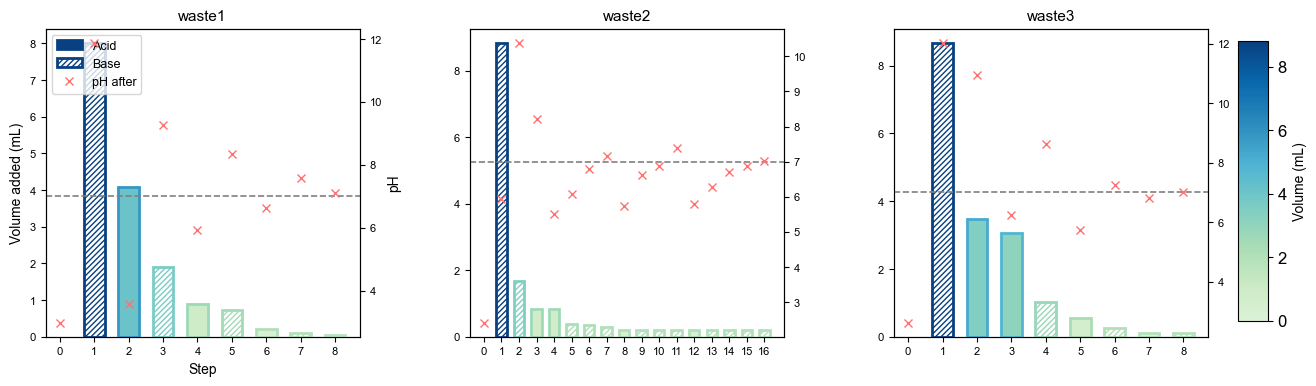

In [ ]:
if __name__ == "__main__":
    plot_ph_files(
        files=[
            r"C:\Users\ZSY\Desktop\code\ph\写文章\数据\废水\waste1.xlsx",
            r"C:\Users\ZSY\Desktop\code\ph\写文章\数据\废水\waste2.xlsx",
            r"C:\Users\ZSY\Desktop\code\ph\写文章\数据\废水\waste3.xlsx"
        ],
        target_pH=7.0,
        ncols=3,                               # ← 三张子图一行
        figsize_per_subplot=(5.0, 4.0),
        save_path="figures",
        filename=r"C:\Users\ZSY\Desktop\画图3\上传\废水ph调节.svg"
    )


C:\Users\ZSY\AppData\Local\Temp\ipykernel_23156\1707238793.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plasma_orig = cm.get_cmap("GnBu")
C:\Users\ZSY\AppData\Local\Temp\ipykernel_23156\1707238793.py:154: UserWarning: Glyph 34507 (\N{CJK UNIFIED IDEOGRAPH-86CB}) missing from font(s) Arial.
  fig.savefig(out, dpi=300, bbox_inches="tight")
C:\Users\ZSY\AppData\Local\Temp\ipykernel_23156\1707238793.py:154: UserWarning: Glyph 30333 (\N{CJK UNIFIED IDEOGRAPH-767D}) missing from font(s) Arial.
  fig.savefig(out, dpi=300, bbox_inches="tight")
C:\Users\ZSY\AppData\Local\Temp\ipykernel_23156\1707238793.py:154: UserWarning: Glyph 31881 (\N{CJK UNIFIED IDEOGRAPH-7C89}) missing from font(s) Arial.
  fig.savefig(out, dpi=300, bbox_inches="tight")
c:\Users\ZSY\anaconda3\Lib\site-packages\IPython\core\events.py:82: Us

Saved: C:\Users\ZSY\Desktop\画图3\上传\调节蛋白粉pH11.svg


c:\Users\ZSY\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 34507 (\N{CJK UNIFIED IDEOGRAPH-86CB}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ZSY\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 30333 (\N{CJK UNIFIED IDEOGRAPH-767D}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ZSY\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 31881 (\N{CJK UNIFIED IDEOGRAPH-7C89}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


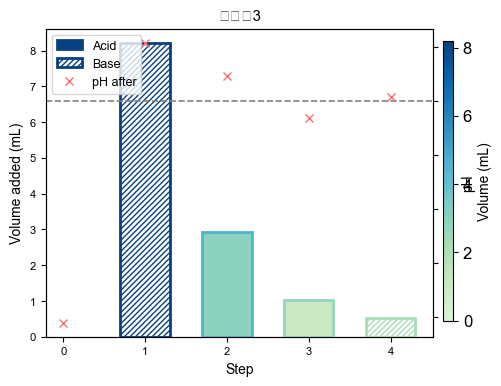

In [16]:
if __name__ == "__main__":
    plot_ph_files(
        files=[
            # r"C:\Users\ZSY\Desktop\code\ph\写文章\数据\蛋白粉\蛋白粉1.xlsx",
            # r"C:\Users\ZSY\Desktop\code\ph\写文章\数据\蛋白粉\蛋白粉2.xlsx",
            r"C:\Users\ZSY\Desktop\code\ph\写文章\数据\蛋白粉\蛋白粉3.xlsx",
            
        ],
        target_pH=11,
        ncols=1,                               # ← 三张子图一行
        figsize_per_subplot=(5.0, 4.0),
        save_path="figures",
        filename=r"C:\Users\ZSY\Desktop\画图3\上传\调节蛋白粉pH11.svg"
    )


C:\Users\ZSY\AppData\Local\Temp\ipykernel_27812\375609990.py:224: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.9, 1])  # leave space for colourbar


Saved figure to: figures\ph_multi.svg


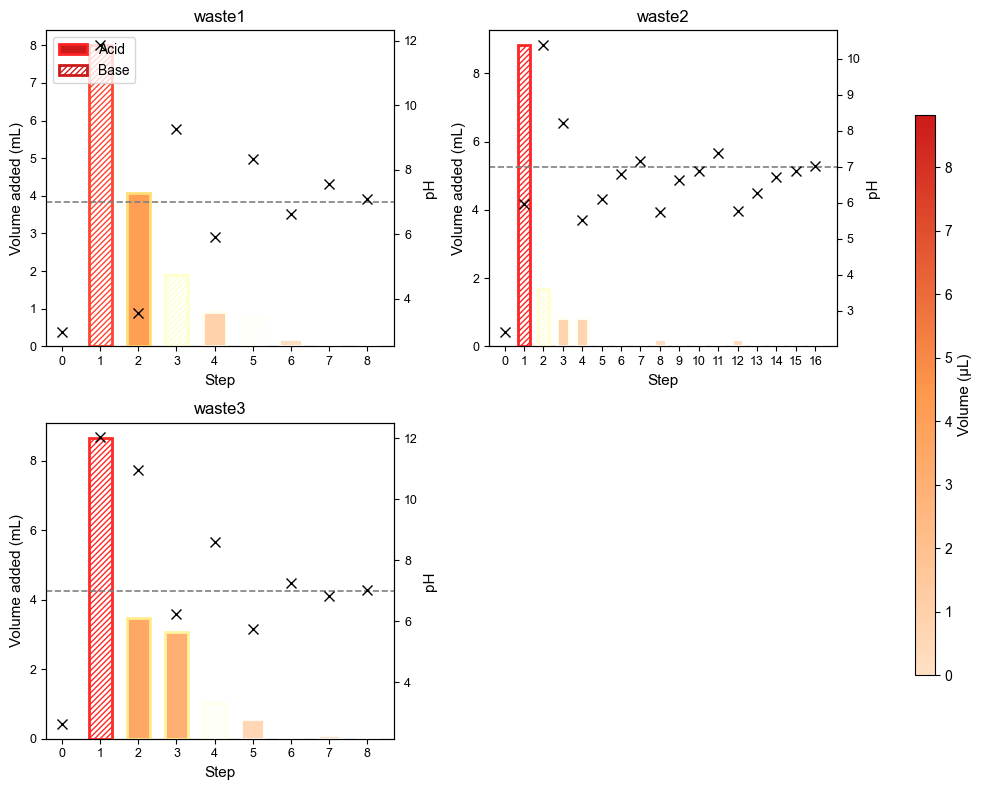

In [ ]:

plot_ph_files(
    files = [
    r"C:\Users\ZSY\Desktop\code\ph\写文章\数据\废水\waste1.xlsx",
    r"C:\Users\ZSY\Desktop\code\ph\写文章\数据\废水\waste2.xlsx",
    r"C:\Users\ZSY\Desktop\code\ph\写文章\数据\废水\waste3.xlsx"
],
    target_pH=7.0,
    ncols=2,
    save_path="figures",
    filename="ph_multi.svg"
)


In [13]:
import pandas as pd
import numpy as np
from pathlib import Path

def get_step0_ph(file_path: str) -> float:
    """Return the pH value of step 0 for a given step-wise pH file."""
    fp = Path(file_path)
    if fp.suffix.lower() == ".csv":
        df = pd.read_csv(fp)
    elif fp.suffix.lower() in {".xls", ".xlsx"}:
        df = pd.read_excel(fp)
    else:
        raise ValueError(f"Unsupported file type: {fp.suffix}")

    # 如果没有显式 step=0，按绘图脚本规则插一行
    if "step" not in df.columns or df.loc[0, "step"] != 0:
        step0 = dict(step=0,
                     reagent="none",
                     volume=0.0,
                     pH_before=df.loc[0, "pH_before"],
                     pH_after=df.loc[0, "pH_before"],
                     pH_change=0.0)
        df = pd.concat([pd.DataFrame([step0]), df], ignore_index=True)

    # 提取 step0 的 pH_after（或 pH_before 都行）
    step0_ph = df.loc[df["step"] == 0, "pH_after"].iloc[0]
    return float(step0_ph)


# ---------- 用法示例 ----------
if __name__ == "__main__":
    path = r"C:\Users\ZSY\Desktop\code\ph\写文章\数据\蛋白粉\蛋白粉1.xlsx"
    ph0  = get_step0_ph(path)
    print(f"Step 0 的 pH 值为：{ph0:.2f}")


Step 0 的 pH 值为：6.90


In [12]:
from __future__ import annotations
import os
from typing import List, Sequence, Union
from matplotlib.lines import Line2D

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle, Patch


# ---------------------- 辅助函数 ----------------------
def _darken_rgba(rgba: tuple[float, float, float, float],
                 factor: float = 1.3) -> tuple[float, float, float, float]:
    r, g, b, a = rgba
    return (min(r * factor, 1.0),
            min(g * factor, 1.0),
            min(b * factor, 1.0),
            a)


def _read_file(path: str) -> pd.DataFrame:
    if path.lower().endswith(".csv"):
        df = pd.read_csv(path)
    elif path.lower().endswith((".xls", ".xlsx")):
        df = pd.read_excel(path)
    else:
        raise ValueError(f"Unsupported file extension: {path}")

    if "step" not in df.columns or df["step"].isnull().any():
        df.insert(0, "step", np.arange(1, len(df) + 1, dtype=int))
    df["step"] = df["step"].astype(int)

    # prepend step-0
    step0 = dict(step=0,
                 reagent="none",
                 volume=0.0,
                 pH_before=df.loc[0, "pH_before"],
                 pH_after=df.loc[0, "pH_before"],
                 pH_change=0.0)
    return pd.concat([pd.DataFrame([step0]), df], ignore_index=True)


# ---------------------- 主函数 ----------------------
def plot_ph_files(
        files: List[str],
        target_pH: Union[float, Sequence[float]] = 7.0,
        figsize_per_subplot: tuple[float, float] = (5.0, 4.0),
        save_path: str | None = None,
        filename: str = "ph_multi.svg"
    ) -> None:
    """
    files     : 每个 CSV/XLSX 路径
    target_pH : 单值或与 files 等长的序列，为每张子图绘目标 pH
    """

    dfs = [_read_file(f) for f in files]
    nplots = len(dfs)

    # ---------- 解析 target_pH ----------
    if isinstance(target_pH, (list, tuple, np.ndarray)):
        if len(target_pH) != nplots:
            raise ValueError("Length of target_pH list must equal number of files")
        tp_list = list(map(float, target_pH))
    else:
        tp_list = [float(target_pH)] * nplots

    # ---------- colormap & normalisation ----------
    cmap_orig   = cm.get_cmap("GnBu")
    custom_cmap = LinearSegmentedColormap.from_list(
        "plasma_trunc", cmap_orig(np.linspace(0.15, 1, 256))
    )

    all_vols = pd.concat([df["volume"] for df in dfs])
    vol_norm = mcolors.Normalize(vmin=all_vols.min(), vmax=all_vols.max())

    # ---------- figure grid（单行） ----------
    nrows = 1
    ncols = nplots
    fig_w = figsize_per_subplot[0] * ncols
    fig_h = figsize_per_subplot[1]               # 仅一行
    fig, axes = plt.subplots(nrows, ncols,
                             figsize=(fig_w, fig_h),
                             squeeze=False, sharey=False)
    axes_flat = axes.flatten()

    # ---------- 主循环 ----------
    for idx, (ax, df, path) in enumerate(zip(axes_flat, dfs, files)):
        steps, volumes, pH_aft = df["step"], df["volume"], df["pH_after"]

        # --- 画体积柱 ---
        for st, vol, reagent in zip(steps, volumes, df["reagent"]):
            fill_c = custom_cmap(vol_norm(vol)) if reagent != "none" else (0.8, 0.8, 0.8, 1)
            edge_c = custom_cmap(min(vol_norm(vol) + 0.20, 1.0))

            if reagent == "acid":
                ax.bar(st, vol, width=0.6, color=fill_c,
                       edgecolor=edge_c, linewidth=2.0, zorder=3)
            elif reagent == "base":
                ax.add_patch(Rectangle((st - 0.3, 0), 0.6, vol,
                                       facecolor="none", edgecolor=edge_c,
                                       linewidth=2.0, hatch="//////", zorder=3))
                ax.bar(st, vol, width=0.6, color=fill_c,
                       edgecolor=edge_c, alpha=0.0)

        # --- pH 轨迹及目标线 ---
        ax2 = ax.twinx()
        ax2.plot(steps, pH_aft, marker="x", ls="None",
                 color="#FF7070", markersize=6, zorder=4)
        ax2.axhline(tp_list[idx], color="gray",
                    ls="--", lw=1.2, zorder=2)

        # --- 标题与标签 ---
        title_txt = os.path.splitext(os.path.basename(path))[0]
        ax.set_title(title_txt, fontsize=16, fontfamily="Arial")

        ax.set_xlabel("Step", fontsize=16)
        ax.set_ylabel("Volume added (mL)", fontsize=16)
        ax2.set_ylabel("pH", fontsize=16)

        # --- ticks & limits ---
        even_steps = [st for st in steps if st % 2 == 0]
        ax.set_xticks(even_steps)
        ax.tick_params(labelsize=12)
        ax2.tick_params(labelsize=12)
        ax.set_ylim(bottom=0)
        ax.grid(False); ax2.grid(False)

    # ---------- 共同色条 ----------
    cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.6])  # 手动调整位置以适配单行
    cb = plt.colorbar(cm.ScalarMappable(norm=vol_norm, cmap=custom_cmap),
                      cax=cbar_ax)
    cb.set_label("Volume (mL)", fontsize=12)

    # ---------- 图例 ----------
    deep_col = custom_cmap(1.0)
    legend_elems = [
        Patch(facecolor=deep_col, edgecolor=deep_col,
              label="Acid", linewidth=2.0),
        Patch(facecolor="none", edgecolor=deep_col, hatch="//////",
              label="Base", linewidth=2.0),
        Line2D([0], [0], marker="x", ls="None",
               markeredgecolor="#FF7070", markersize=6,
               label="pH after"),
    ]
    axes_flat[0].legend(handles=legend_elems, loc="upper left", fontsize=11)

    fig.subplots_adjust(wspace=0.35, hspace=0.25)

    # ---------- 保存 / 显示 ----------
    if save_path:
        os.makedirs(save_path, exist_ok=True)
        out_path = os.path.join(save_path, filename)
        fig.savefig(out_path, dpi=300, bbox_inches="tight")
        print(f"Saved: {out_path}")
    else:
        plt.show()


# --------------------------- 示例调用 ----------------------------
# files = ["run1.csv", "run2.csv", "run3.csv"]
# plot_ph_files(files, target_pH=[7, 7, 7])


C:\Users\ZSY\AppData\Local\Temp\ipykernel_22988\3264894054.py:72: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_orig   = cm.get_cmap("GnBu")
C:\Users\ZSY\AppData\Local\Temp\ipykernel_22988\3264894054.py:157: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missing from font(s) Arial.
  fig.savefig(out_path, dpi=300, bbox_inches="tight")
C:\Users\ZSY\AppData\Local\Temp\ipykernel_22988\3264894054.py:157: UserWarning: Glyph 39564 (\N{CJK UNIFIED IDEOGRAPH-9A8C}) missing from font(s) Arial.
  fig.savefig(out_path, dpi=300, bbox_inches="tight")
C:\Users\ZSY\AppData\Local\Temp\ipykernel_22988\3264894054.py:157: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from font(s) Arial.
  fig.savefig(out_path, dpi=300, bbox_inches="tight")
C:\Users\ZSY\AppData\Local\Temp\ipykernel_22988\3264894

Saved: C:\Users\ZSY\Desktop\画图3\上传\SSA调pH9-10.svg


c:\Users\ZSY\anaconda3\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missing from font(s) Arial.
  func(*args, **kwargs)
c:\Users\ZSY\anaconda3\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 39564 (\N{CJK UNIFIED IDEOGRAPH-9A8C}) missing from font(s) Arial.
  func(*args, **kwargs)
c:\Users\ZSY\anaconda3\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from font(s) Arial.
  func(*args, **kwargs)
c:\Users\ZSY\anaconda3\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 24535 (\N{CJK UNIFIED IDEOGRAPH-5FD7}) missing from font(s) Arial.
  func(*args, **kwargs)
c:\Users\ZSY\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ZSY\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: G

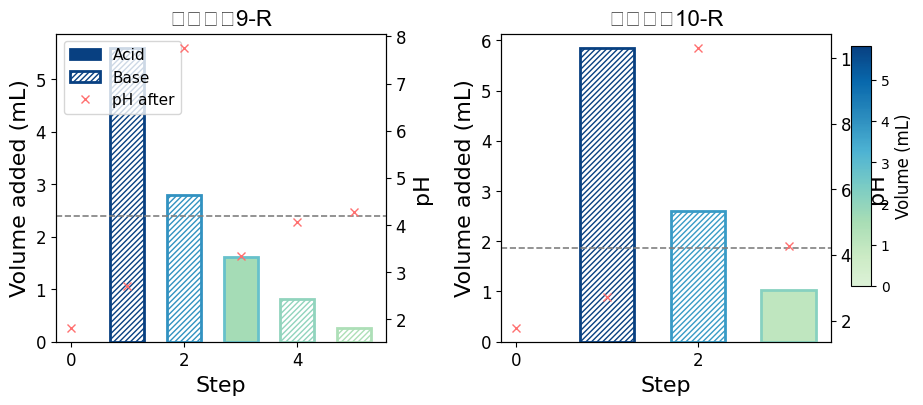

In [ ]:
if __name__ == "__main__":
    plot_ph_files(
        files=[
            r"C:\Users\ZSY\Desktop\code\ph\写文章\数据\SSA\实验日志9-R.xlsx",
            r"C:\Users\ZSY\Desktop\code\ph\写文章\数据\SSA\实验日志10-R.xlsx",
            # r"C:\Users\ZSY\Desktop\code\ph\写文章\数据\SSA\实验日志3-R.xlsx",
        ],
        target_pH=[4.2,4.2],          # ← 为三张子图分别设定目标 pH
       
        figsize_per_subplot=(5.0, 4.0),
        save_path="figures",
        filename=r"C:\Users\ZSY\Desktop\画图3\上传\SSA调pH9-10.svg"
    )


C:\Users\ZSY\AppData\Local\Temp\ipykernel_36748\3012010394.py:112: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_orig   = cm.get_cmap("GnBu")


Saved: C:\Users\ZSY\Desktop\画图3\整理\multi_pH混合酸.svg


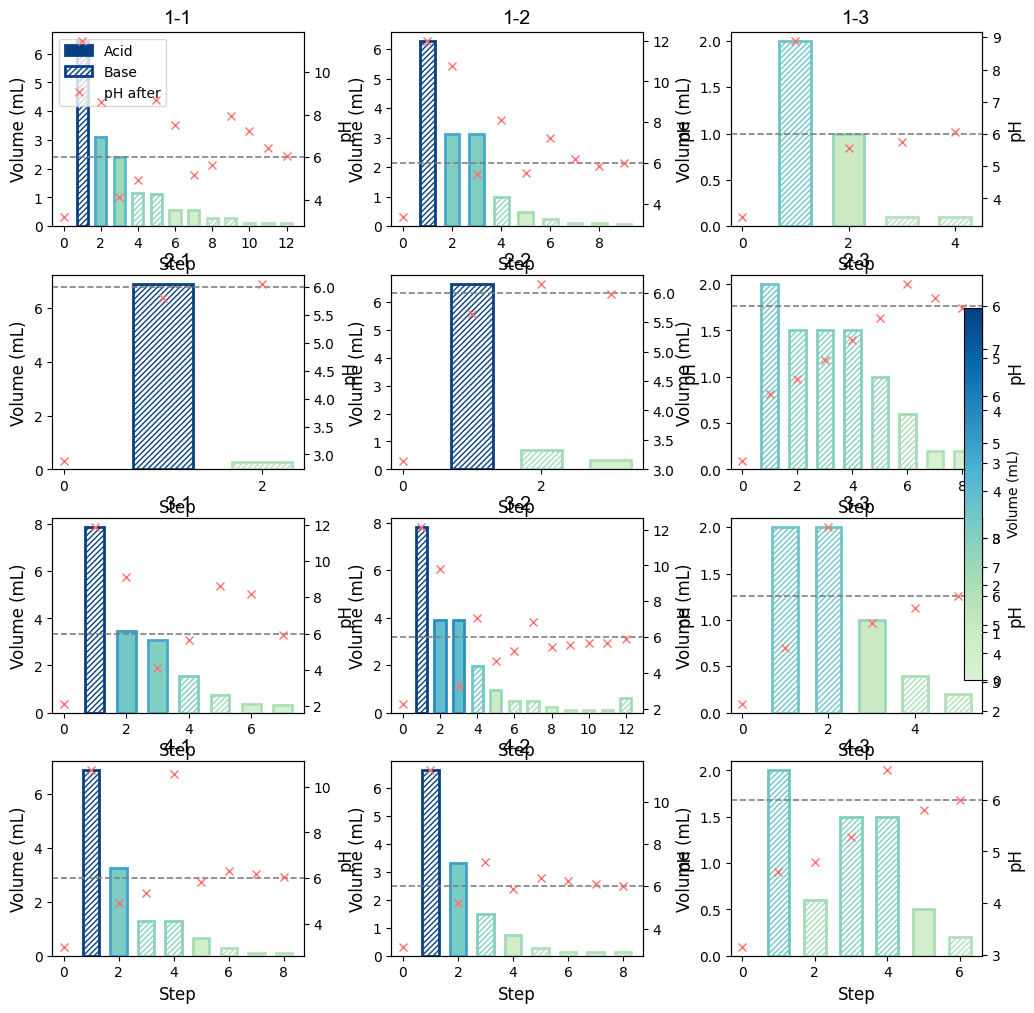

In [ ]:
from __future__ import annotations
import os
from typing import List, Sequence, Union, Optional, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle, Patch
from matplotlib.lines import Line2D


# ---------------------- 辅助函数 ----------------------
def _darken_rgba(rgba: tuple[float, float, float, float],
                 factor: float = 1.3) -> tuple[float, float, float, float]:
    """略微加深一个 RGBA 颜色（不超出 1.0）"""
    r, g, b, a = rgba
    return (min(r * factor, 1.0),
            min(g * factor, 1.0),
            min(b * factor, 1.0),
            a)


def _read_file(path: str) -> pd.DataFrame:
    """读取 CSV/XLSX，确保有 step 列，并在前面插入 step=0 的初始行"""
    if path.lower().endswith(".csv"):
        df = pd.read_csv(path)
    elif path.lower().endswith((".xls", ".xlsx")):
        df = pd.read_excel(path)
    else:
        raise ValueError(f"Unsupported file extension: {path!r}")

    # 如果没有 step 或者存在缺失，就重建 step 列
    if "step" not in df.columns or df["step"].isnull().any():
        df.insert(0, "step", np.arange(1, len(df) + 1, dtype=int))
    df["step"] = df["step"].astype(int)

    # 插入 step0
    step0 = dict(
        step=0,
        reagent="none",
        volume=0.0,
        pH_before=df.loc[0, "pH_before"],
        pH_after=df.loc[0, "pH_before"],
        pH_change=0.0,
    )
    return pd.concat([pd.DataFrame([step0]), df], ignore_index=True)


# ---------------------- 主函数 ----------------------
def plot_ph_files(
    files: List[str],
    target_pH: Union[float, Sequence[float]] = 7.0,
    nrows: int = 1,
    ncols: Optional[int] = None,
    figsize_per_subplot: Tuple[float, float] = (5.0, 4.0),
    font_title: str = "Arial",
    font_size_title: float = 16,
    font_size_label: float = 16,
    font_size_tick: float = 12,
    save_path: Optional[str] = None,
    filename: str = "ph_multi.svg",
) -> None:
    """
    绘制多条 pH 调整曲线，支持自定义子图排列、字体、目标 pH 等。

    Parameters
    ----------
    files : List[str]
        要读取的 CSV/XLSX 文件路径列表。
    target_pH : float or Sequence[float]
        单一目标 pH，或与 files 等长的目标 pH 列表。
    nrows : int
        子图行数。
    ncols : int or None
        子图列数；若为 None，则自动计算为 ceil(nplots / nrows)。
    figsize_per_subplot : (width, height)
        每个子图的大小（英寸）。
    font_title : str
        子图标题字体。
    font_size_title : float
        子图标题字号。
    font_size_label : float
        坐标轴标签字号。
    font_size_tick : float
        刻度字号。
    save_path : str or None
        若不为 None，则保存到指定文件夹；否则直接 plt.show()。
    filename : str
        保存文件名（仅在 save_path 不为 None 时使用）。
    """

    # 1. 读取所有 DataFrame
    dfs = [_read_file(f) for f in files]
    nplots = len(dfs)

    # 2. 解析 target_pH
    if isinstance(target_pH, (list, tuple, np.ndarray)):
        if len(target_pH) != nplots:
            raise ValueError("Length of target_pH must equal number of files")
        tp_list = list(map(float, target_pH))
    else:
        tp_list = [float(target_pH)] * nplots

    # 3. 自动计算 ncols
    if ncols is None:
        ncols = int(np.ceil(nplots / nrows))

    # 4. 准备 colormap & normalization
    cmap_orig   = cm.get_cmap("GnBu")
    custom_cmap = LinearSegmentedColormap.from_list(
        "custom_GnBu", cmap_orig(np.linspace(0.15, 1, 256))
    )
    all_vols = pd.concat([df["volume"] for df in dfs])
    vol_norm = mcolors.Normalize(vmin=all_vols.min(), vmax=all_vols.max())

    # 5. 创建 subplots
    fig_w = figsize_per_subplot[0] * ncols
    fig_h = figsize_per_subplot[1] * nrows
    fig, axes = plt.subplots(nrows, ncols,
                             figsize=(fig_w, fig_h),
                             squeeze=False)
    axes_flat = axes.flatten()

    # 6. 绘图循环
    for idx, (df, path) in enumerate(zip(dfs, files)):
        ax = axes_flat[idx]
        steps = df["step"]
        volumes = df["volume"]
        pH_after = df["pH_after"]
        reagents = df["reagent"]

        # —— 柱状图：酸／碱 —— 
        for st, vol, reagent in zip(steps, volumes, reagents):
            face = custom_cmap(vol_norm(vol)) if reagent != "none" else (0.8, 0.8, 0.8, 1)
            edge = custom_cmap(min(vol_norm(vol) + 0.2, 1.0))
            if reagent == "acid":
                ax.bar(st, vol, width=0.6,
                       color=face, edgecolor=edge, linewidth=2.0, zorder=3)
            elif reagent == "base":
                ax.add_patch(Rectangle((st - 0.3, 0), 0.6, vol,
                                       facecolor="none",
                                       edgecolor=edge,
                                       linewidth=2.0,
                                       hatch="//////",
                                       zorder=3))
                ax.bar(st, vol, width=0.6,
                       color=face, edgecolor=edge, alpha=0.0)

        # —— pH 折线＋目标线 —— 
        ax2 = ax.twinx()
        ax2.plot(steps, pH_after, marker="x", ls="None",
                 color="#FF7070", markersize=6, zorder=4)
        ax2.axhline(tp_list[idx], color="gray",
                    ls="--", lw=1.2, zorder=2)

        # —— 标题与标签字体 —— 
        title_txt = os.path.splitext(os.path.basename(path))[0]
        ax.set_title(title_txt,
                     fontfamily=font_title,
                     fontsize=font_size_title)
        ax.set_xlabel("Step", fontsize=font_size_label)
        ax.set_ylabel("Volume (mL)", fontsize=font_size_label)
        ax2.set_ylabel("pH", fontsize=font_size_label)

        # —— 刻度字号、网格、范围 —— 
        evens = [st for st in steps if st % 2 == 0]
        ax.set_xticks(evens)
        ax.tick_params(labelsize=font_size_tick)
        ax2.tick_params(labelsize=font_size_tick)
        ax.set_ylim(bottom=0)
        ax.grid(False)
        ax2.grid(False)

    # 如果子图数目不足，隐藏多余的轴
    for j in range(nplots, len(axes_flat)):
        axes_flat[j].axis("off")

    # 7. 共享 colorbar
    sm = cm.ScalarMappable(norm=vol_norm, cmap=custom_cmap)
    sm.set_array([])
    fig.colorbar(sm,
                 ax=axes_flat,
                 orientation="vertical",
                 fraction=0.02,
                 pad=0.04,
                 label="Volume (mL)")

    # 8. 图例（只加在第一个子图上）
    deep_col = custom_cmap(1.0)
    legend_elems = [
        Patch(facecolor=deep_col, edgecolor=deep_col,
              label="Acid", linewidth=2.0),
        Patch(facecolor="none", edgecolor=deep_col,
              hatch="//////", label="Base", linewidth=2.0),
        Line2D([0], [0], marker="x", ls="None",
               markeredgecolor="#FF7070", markersize=6,
               label="pH after"),
    ]
    axes_flat[0].legend(handles=legend_elems,
                        loc="upper left",
                        fontsize=font_size_tick)

    fig.subplots_adjust(wspace=0.35, hspace=0.25)

    # 9. 保存或展示
    if save_path:
        os.makedirs(save_path, exist_ok=True)
        outp = os.path.join(save_path, filename)
        fig.savefig(outp, dpi=300, bbox_inches="tight")
        print(f"Saved: {outp}")
    else:
        plt.show()


# --------------------------- 示例调用 ----------------------------
if __name__ == "__main__":
    files = [r"C:\Users\ZSY\Desktop\code\ph\写文章\数据\混合酸\1-1.xlsx",
              r"C:\Users\ZSY\Desktop\code\ph\写文章\数据\混合酸\1-2.xlsx", 
              r"C:\Users\ZSY\Desktop\code\ph\写文章\数据\混合酸\1-3.xlsx", 
              r"C:\Users\ZSY\Desktop\code\ph\写文章\数据\混合酸\2-1.xlsx",
              r"C:\Users\ZSY\Desktop\code\ph\写文章\数据\混合酸\2-2.xlsx",
                   r"C:\Users\ZSY\Desktop\code\ph\写文章\数据\混合酸\2-3.xlsx",
                   r"C:\Users\ZSY\Desktop\code\ph\写文章\数据\混合酸\3-1.xlsx",
                     r"C:\Users\ZSY\Desktop\code\ph\写文章\数据\混合酸\3-2.xlsx",
                     r"C:\Users\ZSY\Desktop\code\ph\写文章\数据\混合酸\3-3.xlsx",
                     r"C:\Users\ZSY\Desktop\code\ph\写文章\数据\混合酸\4-1.xlsx",
                        r"C:\Users\ZSY\Desktop\code\ph\写文章\数据\混合酸\4-2.xlsx",
                        r"C:\Users\ZSY\Desktop\code\ph\写文章\数据\混合酸\4-3.xlsx"
            ]
    target_pH = [6,6,6,6,6,6,6,6,6,6,6,6]
    plot_ph_files(
        files,
        target_pH=target_pH,
        nrows=4,
        ncols=3,
        figsize_per_subplot=(4.0, 3.0),
        font_title="Arial",
        font_size_title=14,
        font_size_label=12,
        font_size_tick=10,
        save_path=r"C:\Users\ZSY\Desktop\画图3\整理"  ,    # 或者 "output_folder"
        filename="multi_pH混合酸.svg"
    )


C:\Users\ZSY\AppData\Local\Temp\ipykernel_36748\642010316.py:86: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_orig   = cm.get_cmap("GnBu")


Saved: C:\Users\ZSY\Desktop\画图3\整理\multi_pH混合酸.svg


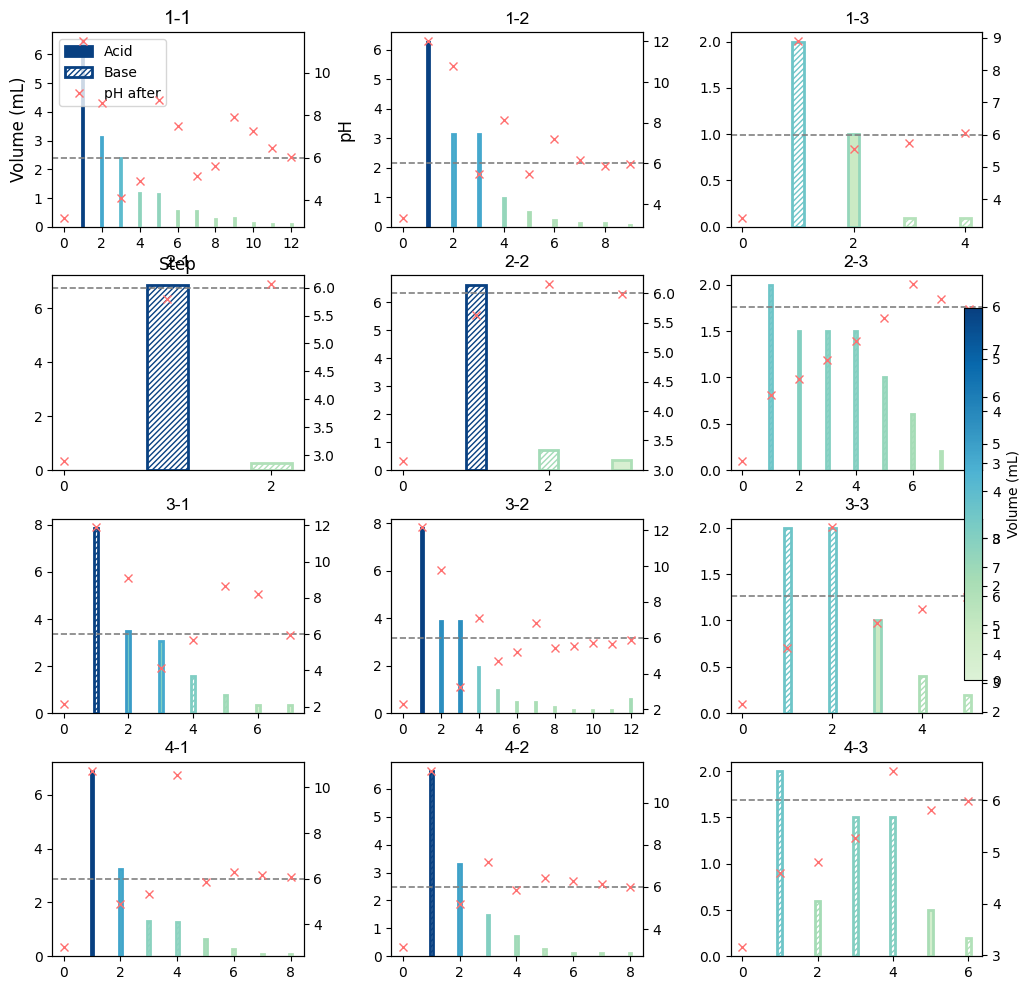

In [12]:
from __future__ import annotations
import os
from typing import List, Sequence, Union, Optional, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle, Patch
from matplotlib.lines import Line2D


# ---------------------- 辅助函数 ----------------------
def _darken_rgba(rgba: tuple[float, float, float, float],
                 factor: float = 1.3) -> tuple[float, float, float, float]:
    r, g, b, a = rgba
    return (min(r * factor, 1.0),
            min(g * factor, 1.0),
            min(b * factor, 1.0),
            a)


def _read_file(path: str) -> pd.DataFrame:
    if path.lower().endswith(".csv"):
        df = pd.read_csv(path)
    elif path.lower().endswith((".xls", ".xlsx")):
        df = pd.read_excel(path)
    else:
        raise ValueError(f"Unsupported file extension: {path!r}")

    if "step" not in df.columns or df["step"].isnull().any():
        df.insert(0, "step", np.arange(1, len(df) + 1, dtype=int))
    df["step"] = df["step"].astype(int)

    step0 = dict(
        step=0,
        reagent="none",
        volume=0.0,
        pH_before=df.loc[0, "pH_before"],
        pH_after=df.loc[0, "pH_before"],
        pH_change=0.0,
    )
    return pd.concat([pd.DataFrame([step0]), df], ignore_index=True)


# ---------------------- 主函数 ----------------------
def plot_ph_files(
    files: List[str],
    target_pH: Union[float, Sequence[float]] = 7.0,
    nrows: int = 1,
    ncols: Optional[int] = None,
    figsize_per_subplot: Tuple[float, float] = (5.0, 4.0),
    font_title: str = "Arial",
    font_size_title: float = 16,
    font_size_label: float = 16,
    font_size_tick: float = 12,
    save_path: Optional[str] = None,
    filename: str = "ph_multi.svg",
) -> None:
    """
    files: 要绘制的 CSV/XLSX 列表
    target_pH: 单值或与 files 等长的目标 pH 列表
    nrows, ncols: 子图行列数
    figsize_per_subplot: 每个子图大小 (inch)
    font_*: 字体配置
    save_path/filename: 保存
    """
    dfs = [_read_file(f) for f in files]
    nplots = len(dfs)

    # 解析 target_pH
    if isinstance(target_pH, (list, tuple, np.ndarray)):
        if len(target_pH) != nplots:
            raise ValueError("target_pH 长度必须与 files 一致")
        tp_list = list(map(float, target_pH))
    else:
        tp_list = [float(target_pH)] * nplots

    # 自动计算 ncols
    if ncols is None:
        ncols = int(np.ceil(nplots / nrows))

    # colormap
    cmap_orig   = cm.get_cmap("GnBu")
    custom_cmap = LinearSegmentedColormap.from_list(
        "custom_GnBu", cmap_orig(np.linspace(0.15, 1, 256))
    )
    all_vols = pd.concat([df["volume"] for df in dfs])
    vol_norm = mcolors.Normalize(vmin=all_vols.min(), vmax=all_vols.max())

    # 创建 figure/subplots
    fig_w = figsize_per_subplot[0] * ncols
    fig_h = figsize_per_subplot[1] * nrows
    fig, axes = plt.subplots(nrows, ncols,
                             figsize=(fig_w, fig_h),
                             squeeze=False)
    axes_flat = axes.flatten()

    for idx, (df, path) in enumerate(zip(dfs, files)):
        ax = axes_flat[idx]
        steps    = df["step"]
        volumes  = df["volume"]
        pH_after = df["pH_after"]
        reagents = df["reagent"]

        # 根据非“none”试剂步数动态计算柱宽
        count_bars = int((df["reagent"] != "none").sum())
        width = min(0.6, 0.8 / count_bars) if count_bars > 0 else 0.6

        # 绘制酸/碱柱
        for st, vol, reagent in zip(steps, volumes, reagents):
            face = custom_cmap(vol_norm(vol)) if reagent != "none" else (0.8, 0.8, 0.8, 1)
            edge = custom_cmap(min(vol_norm(vol) + 0.2, 1.0))
            if reagent == "acid":
                ax.bar(st, vol, width=width,
                       color=face, edgecolor=edge, linewidth=2.0, zorder=3)
            elif reagent == "base":
                ax.add_patch(Rectangle((st - width/2, 0), width, vol,
                                       facecolor="none",
                                       edgecolor=edge,
                                       linewidth=2.0,
                                       hatch="//////",
                                       zorder=3))
                ax.bar(st, vol, width=width,
                       color=face, edgecolor=edge, alpha=0.0)

        # pH 轨迹 & 目标线
        ax2 = ax.twinx()
        ax2.plot(steps, pH_after, marker="x", ls="None",
                 color="#FF7070", markersize=6, zorder=4)
        ax2.axhline(tp_list[idx], color="gray",
                    ls="--", lw=1.2, zorder=2)

        # 仅第一个子图显示标题 & 坐标轴标签
        title_txt = os.path.splitext(os.path.basename(path))[0]
        if idx == 0:
            ax.set_title(title_txt,
                         fontfamily=font_title,
                         fontsize=font_size_title)
            ax.set_xlabel("Step", fontsize=font_size_label)
            ax.set_ylabel("Volume (mL)", fontsize=font_size_label)
            ax2.set_ylabel("pH", fontsize=font_size_label)
        else:
            ax.set_title(title_txt,
                         fontfamily=font_title,
                         fontsize=font_size_title * 0.9)  # 可以略小一些
            ax.set_xlabel("")
            ax.set_ylabel("")
            ax2.set_ylabel("")

        # 刻度 & 范围
        evens = [st for st in steps if st % 2 == 0]
        ax.set_xticks(evens)
        ax.tick_params(labelsize=font_size_tick)
        ax2.tick_params(labelsize=font_size_tick)
        ax.set_ylim(bottom=0)
        ax.grid(False)
        ax2.grid(False)

    # 隐藏多余子图
    for j in range(nplots, len(axes_flat)):
        axes_flat[j].axis("off")

    # 共享 colorbar
    sm = cm.ScalarMappable(norm=vol_norm, cmap=custom_cmap)
    sm.set_array([])
    fig.colorbar(sm,
                 ax=axes_flat,
                 orientation="vertical",
                 fraction=0.02,
                 pad=0.04,
                 label="Volume (mL)")

    # 图例（仅第一个子图）
    deep_col = custom_cmap(1.0)
    legend_elems = [
        Patch(facecolor=deep_col, edgecolor=deep_col,
              label="Acid", linewidth=2.0),
        Patch(facecolor="none", edgecolor=deep_col,
              hatch="//////", label="Base", linewidth=2.0),
        Line2D([0], [0], marker="x", ls="None",
               markeredgecolor="#FF7070", markersize=6,
               label="pH after"),
    ]
    axes_flat[0].legend(handles=legend_elems,
                        loc="upper left",
                        fontsize=font_size_tick)

    fig.subplots_adjust(wspace=0.35, hspace=0.25)

    # 保存或展示
    if save_path:
        os.makedirs(save_path, exist_ok=True)
        outp = os.path.join(save_path, filename)
        fig.savefig(outp, dpi=300, bbox_inches="tight")
        print(f"Saved: {outp}")
    else:
        plt.show()


# --------------------------- 使用示例 ----------------------------
if __name__ == "__main__":
    files = [r"C:\Users\ZSY\Desktop\code\ph\写文章\数据\混合酸\1-1.xlsx",
              r"C:\Users\ZSY\Desktop\code\ph\写文章\数据\混合酸\1-2.xlsx", 
              r"C:\Users\ZSY\Desktop\code\ph\写文章\数据\混合酸\1-3.xlsx", 
              r"C:\Users\ZSY\Desktop\code\ph\写文章\数据\混合酸\2-1.xlsx",
              r"C:\Users\ZSY\Desktop\code\ph\写文章\数据\混合酸\2-2.xlsx",
                   r"C:\Users\ZSY\Desktop\code\ph\写文章\数据\混合酸\2-3.xlsx",
                   r"C:\Users\ZSY\Desktop\code\ph\写文章\数据\混合酸\3-1.csv",
                     r"C:\Users\ZSY\Desktop\code\ph\写文章\数据\混合酸\3-2.xlsx",
                     r"C:\Users\ZSY\Desktop\code\ph\写文章\数据\混合酸\3-3.xlsx",
                     r"C:\Users\ZSY\Desktop\code\ph\写文章\数据\混合酸\4-1.csv",
                        r"C:\Users\ZSY\Desktop\code\ph\写文章\数据\混合酸\4-2.xlsx",
                        r"C:\Users\ZSY\Desktop\code\ph\写文章\数据\混合酸\4-3.xlsx"
            ]
    target_pH = [6] * 12
    plot_ph_files(
        files,
        target_pH=target_pH,
        nrows=4,           # 4 行
        ncols=3,           # 3 列
        figsize_per_subplot=(4.0, 3.0),
        font_title="Arial",
        font_size_title=14,
        font_size_label=12,
        font_size_tick=10,
        save_path=r"C:\Users\ZSY\Desktop\画图3\整理",
        filename="multi_pH混合酸.svg"
    )


In [3]:
from __future__ import annotations
import os
from typing import List, Sequence, Union, Optional, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle, Patch
from matplotlib.lines import Line2D


def _read_file(path: str) -> pd.DataFrame:
    if path.lower().endswith(".csv"):
        df = pd.read_csv(path)
    elif path.lower().endswith((".xls", ".xlsx")):
        df = pd.read_excel(path)
    else:
        raise ValueError(f"Unsupported file extension: {path!r}")
    if "step" not in df.columns or df["step"].isnull().any():
        df.insert(0, "step", np.arange(1, len(df) + 1, dtype=int))
    df["step"] = df["step"].astype(int)
    step0 = dict(
        step=0,
        reagent="none",
        volume=0.0,
        pH_before=df.loc[0, "pH_before"],
        pH_after=df.loc[0, "pH_before"],
        pH_change=0.0,
    )
    return pd.concat([pd.DataFrame([step0]), df], ignore_index=True)


def plot_ph_files(
    files: List[str],
    target_pH: Union[float, Sequence[float]] = 7.0,
    nrows: int = 4,
    ncols: Optional[int] = 3,
    figsize_per_subplot: Tuple[float, float] = (4.0, 3.0),
    font_size_label: float = 20,
    font_size_tick: float = 16,
    margins: Tuple[float, float, float, float] = (0.08, 0.15, 0.06, 0.94),
        # (left, legend_width, bottom, top)
    wspace: float = 0.3,    # 横向子图间距调小到 0.3
    hspace: float = 0.5,    # 纵向子图间距保持 0.5
    save_path: Optional[str] = None,
    filename: str = "ph_multi.svg",
) -> None:
    """
    files: 要绘制的 CSV/XLSX 路径列表
    target_pH: 单值或与 files 等长的目标 pH 列表
    nrows/ncols: 子图行列数
    figsize_per_subplot: 每个子图大小 (inch)
    font_size_label: 坐标轴标签字号
    font_size_tick: 刻度字号
    margins: (left, legend_width, bottom, top) 子图区域与图例/色条的留白
    wspace/hspace: 子图间距（横向 0.3，纵向 0.5）
    save_path/filename: 保存路径与文件名
    """
    # 1. 读取数据
    dfs = [_read_file(f) for f in files]
    nplots = len(dfs)

    # 2. 解析 target_pH
    if isinstance(target_pH, (list, tuple, np.ndarray)):
        if len(target_pH) != nplots:
            raise ValueError("target_pH 长度必须与 files 一致")
        tp_list = list(map(float, target_pH))
    else:
        tp_list = [float(target_pH)] * nplots

    # 3. colormap & 归一化
    cmap_orig   = cm.get_cmap("GnBu")
    custom_cmap = LinearSegmentedColormap.from_list(
        "custom_GnBu", cmap_orig(np.linspace(0.15, 1, 256))
    )
    all_vols = pd.concat([df["volume"] for df in dfs])
    vol_norm = mcolors.Normalize(vmin=all_vols.min(), vmax=all_vols.max())

    # 4. A4 纵向比例设置
    fig_w = figsize_per_subplot[0] * ncols
    a4_ratio = 210 / 297
    fig_h = fig_w / a4_ratio

    # 5. 创建画布和子图
    left, legend_w, bottom, top = margins
    right = 1 - legend_w
    fig, axes = plt.subplots(nrows, ncols,
                             figsize=(fig_w, fig_h),
                             squeeze=False)
    axes_flat = axes.flatten()

    # 6. 动态柱宽预处理
    bars_counts = [(df["reagent"] != "none").sum() for df in dfs]
    max_bars = max(bars_counts) if bars_counts else 1
    width_max = 0.6

    for idx, (df, path) in enumerate(zip(dfs, files)):
        ax = axes_flat[idx]
        steps    = df["step"]
        volumes  = df["volume"]
        pH_after = df["pH_after"]
        reagents = df["reagent"]

        # 动态计算柱宽
        count = bars_counts[idx]
        width = width_max * (count / max_bars) if max_bars > 0 else width_max

        # 绘制酸/碱柱状
        for st, vol, reagent in zip(steps, volumes, reagents):
            face = custom_cmap(vol_norm(vol)) if reagent != "none" else (0.8,0.8,0.8,1)
            edge = custom_cmap(min(vol_norm(vol)+0.2, 1.0))
            if reagent == "acid":
                ax.bar(st, vol, width=width,
                       color=face, edgecolor=edge,
                       linewidth=2.0, zorder=3)
            else:
                hatch = "//////" if reagent == "base" else None
                ax.add_patch(Rectangle((st-width/2,0), width, vol,
                                       facecolor="none", edgecolor=edge,
                                       linewidth=2.0, hatch=hatch, zorder=3))
                ax.bar(st, vol, width=width,
                       color=face, edgecolor=edge, alpha=0.0)

        # pH 曲线 & 目标线
        ax2 = ax.twinx()
        ax2.plot(steps, pH_after, marker="x", ls="None",
                 color="#FF7070", markersize=8, zorder=4)
        ax2.axhline(tp_list[idx], color="gray", ls="--", lw=1.5, zorder=2)

        # 仅首图显示轴标签
        if idx == 0:
            ax.set_xlabel("Step", fontsize=font_size_label)
            ax.set_ylabel("Volume (mL)", fontsize=font_size_label)
            ax2.set_ylabel("pH", fontsize=font_size_label)
        else:
            ax.set_xlabel("")
            ax.set_ylabel("")
            ax2.set_ylabel("")

        ax.set_ylim(bottom=0)
        evens = [st for st in steps if st % 2 == 0]
        ax.set_xticks(evens)
        ax.tick_params(labelsize=font_size_tick)
        ax2.tick_params(labelsize=font_size_tick)
        ax.grid(False)
        ax2.grid(False)

    # 隐藏多余子图
    for j in range(nplots, len(axes_flat)):
        axes_flat[j].axis("off")

    # 7. 共享 colorbar
    sm = cm.ScalarMappable(norm=vol_norm, cmap=custom_cmap)
    sm.set_array([])
    cax = fig.add_axes([right+0.02, bottom, 0.02, top-bottom])
    cbar = fig.colorbar(sm, cax=cax, orientation="vertical", label="Volume (mL)")
    cbar.ax.tick_params(labelsize=font_size_tick)
    cbar.ax.yaxis.label.set_size(font_size_label)

    # 8. 图例
    leg_ax = fig.add_axes([right+0.06, bottom, legend_w-0.08, top-bottom])
    leg_ax.axis("off")
    deep_col = custom_cmap(1.0)
    legend_elems = [
        Patch(facecolor=deep_col, edgecolor=deep_col, label="Acid", linewidth=2.0),
        Patch(facecolor="none", edgecolor=deep_col, hatch="//////", label="Base", linewidth=2.0),
        Line2D([0],[0], marker="x", ls="None", markeredgecolor="#FF7070", markersize=8, label="pH after"),
    ]
    leg_ax.legend(handles=legend_elems, loc="center", fontsize=font_size_tick)

    # 9. 调整间距
    fig.subplots_adjust(left=left, right=right, bottom=bottom, top=top,
                        wspace=wspace, hspace=hspace)

    # 10. 保存或显示
    if save_path:
        os.makedirs(save_path, exist_ok=True)
        outp = os.path.join(save_path, filename)
        fig.savefig(outp, dpi=300, bbox_inches="tight")
        print(f"Saved: {outp}")
    else:
        plt.show()


In [ ]:
from __future__ import annotations
import os
from typing import List, Sequence, Union, Optional, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle, Patch
from matplotlib.lines import Line2D


def _read_file(path: str) -> pd.DataFrame:
    if path.lower().endswith(".csv"):
        df = pd.read_csv(path)
    elif path.lower().endswith((".xls", ".xlsx")):
        df = pd.read_excel(path)
    else:
        raise ValueError(f"Unsupported file extension: {path!r}")
    if "step" not in df.columns or df["step"].isnull().any():
        df.insert(0, "step", np.arange(1, len(df) + 1, dtype=int))
    df["step"] = df["step"].astype(int)
    step0 = dict(
        step=0,
        reagent="none",
        volume=0.0,
        pH_before=df.loc[0, "pH_before"],
        pH_after=df.loc[0, "pH_before"],
        pH_change=0.0,
    )
    return pd.concat([pd.DataFrame([step0]), df], ignore_index=True)


def plot_ph_files(
    files: List[str],
    target_pH: Union[float, Sequence[float]] = 7.0,
    nrows: int = 4,
    ncols: Optional[int] = 3,
    figsize_per_subplot: Tuple[float, float] = (4.0, 3.0),
    font_size_label: float = 20,
    font_size_tick: float = 16,
    font_size_xtick: float = 12,               # ← 新增：横轴刻度字号
    margins: Tuple[float, float, float, float] = (0.08, 0.15, 0.06, 0.94),
    wspace: float = 0.3,
    hspace: float = 0.5,
    save_path: Optional[str] = None,
    filename: str = "ph_multi.svg",
) -> None:
    """
    files: 要绘制的 CSV/XLSX 路径列表
    target_pH: 单值或与 files 等长的目标 pH 列表
    nrows/ncols: 子图行列数
    figsize_per_subplot: 每个子图大小 (inch)
    font_size_label: 坐标轴标签字号
    font_size_tick: 纵轴刻度字号
    font_size_xtick: 横轴刻度字号
    margins: (left, legend_width, bottom, top)
    wspace/hspace: 子图间距
    save_path/filename: 保存路径与文件名
    """
    dfs = [_read_file(f) for f in files]
    nplots = len(dfs)

    if isinstance(target_pH, (list, tuple, np.ndarray)):
        if len(target_pH) != nplots:
            raise ValueError("target_pH 长度必须与 files 一致")
        tp_list = list(map(float, target_pH))
    else:
        tp_list = [float(target_pH)] * nplots

    # colormap & normalize
    cmap_orig   = cm.get_cmap("GnBu")
    custom_cmap = LinearSegmentedColormap.from_list(
        "custom_GnBu", cmap_orig(np.linspace(0.15, 1, 256))
    )
    all_vols = pd.concat([df["volume"] for df in dfs])
    vol_norm = mcolors.Normalize(vmin=all_vols.min(), vmax=all_vols.max())

    # A4 纵向比例
    fig_w = figsize_per_subplot[0] * ncols
    a4_ratio = 210 / 297
    fig_h = fig_w / a4_ratio

    left, legend_w, bottom, top = margins
    right = 1 - legend_w
    fig, axes = plt.subplots(nrows, ncols,
                             figsize=(fig_w, fig_h),
                             squeeze=False)
    axes_flat = axes.flatten()

    bars_counts = [(df["reagent"] != "none").sum() for df in dfs]
    max_bars = max(bars_counts) if bars_counts else 1
    width_max = 0.6

    for idx, (df, path) in enumerate(zip(dfs, files)):
        ax = axes_flat[idx]
        steps    = df["step"]
        volumes  = df["volume"]
        pH_after = df["pH_after"]
        reagents = df["reagent"]

        count = bars_counts[idx]
        width = width_max * (count / max_bars) if max_bars > 0 else width_max

        # 柱状图
        for st, vol, reagent in zip(steps, volumes, reagents):
            face = custom_cmap(vol_norm(vol)) if reagent != "none" else (0.8,0.8,0.8,1)
            edge = custom_cmap(min(vol_norm(vol)+0.2, 1.0))
            if reagent == "acid":
                ax.bar(st, vol, width=width,
                       color=face, edgecolor=edge, linewidth=2.0, zorder=3)
            else:
                hatch = "//////" if reagent=="base" else None
                ax.add_patch(Rectangle((st-width/2,0), width, vol,
                                       facecolor="none", edgecolor=edge,
                                       linewidth=2.0, hatch=hatch, zorder=3))
                ax.bar(st, vol, width=width,
                       color=face, edgecolor=edge, alpha=0.0)

        # pH 曲线 & 目标线
        ax2 = ax.twinx()
        ax2.plot(steps, pH_after, marker="x", ls="None",
                 color="#FF7070", markersize=8, zorder=4)
        ax2.axhline(tp_list[idx], color="gray", ls="--", lw=1.5, zorder=2)

        # 仅首图显示轴标签
        if idx == 0:
            ax.set_xlabel("Step", fontsize=font_size_label)
            ax.set_ylabel("Volume (mL)", fontsize=font_size_label)
            ax2.set_ylabel("pH", fontsize=font_size_label)
        else:
            ax.set_xlabel("")
            ax.set_ylabel("")
            ax2.set_ylabel("")

        # 刻度 & 范围
        ax.set_ylim(bottom=0)
        evens = [st for st in steps if st % 2 == 0]
        ax.set_xticks(evens)
        ax.tick_params(axis='x', labelsize=font_size_xtick)   # ← 横轴
        ax.tick_params(axis='y', labelsize=font_size_tick)     # ← 纵轴
        ax2.tick_params(labelsize=font_size_tick)
        ax.grid(False)
        ax2.grid(False)

    # 隐藏多余子图
    for j in range(nplots, len(axes_flat)):
        axes_flat[j].axis("off")

    # 共享 colorbar
    sm = cm.ScalarMappable(norm=vol_norm, cmap=custom_cmap)
    sm.set_array([])
    cax = fig.add_axes([right+0.02, bottom, 0.02, top-bottom])
    cbar = fig.colorbar(sm, cax=cax, orientation="vertical", label="Volume (mL)")
    cbar.ax.tick_params(labelsize=font_size_tick)
    cbar.ax.yaxis.label.set_size(font_size_label)

    # 图例
    leg_ax = fig.add_axes([right+0.06, bottom, legend_w-0.08, top-bottom])
    leg_ax.axis("off")
    deep_col = custom_cmap(1.0)
    legend_elems = [
        Patch(facecolor=deep_col, edgecolor=deep_col, label="Acid", linewidth=2.0),
        Patch(facecolor="none", edgecolor=deep_col, hatch="//////", label="Base", linewidth=2.0),
        Line2D([0],[0], marker="x", ls="None", markeredgecolor="#FF7070", markersize=8, label="pH after"),
    ]
    leg_ax.legend(handles=legend_elems, loc="center", fontsize=font_size_tick)

    # 调整间距
    fig.subplots_adjust(left=left, right=right, bottom=bottom, top=top,
                        wspace=wspace, hspace=hspace)

    if save_path:
        os.makedirs(save_path, exist_ok=True)
        outp = os.path.join(save_path, filename)
        fig.savefig(outp, dpi=300, bbox_inches="tight")
        print(f"Saved: {outp}")
    else:
        plt.show()


# --------------------------- 使用示例 ----------------------------
if __name__ == "__main__":
    files = [r"C:\Users\ZSY\Desktop\code\ph\写文章\数据\蛋白粉\蛋白粉1.xlsx",
              r"C:\Users\ZSY\Desktop\code\ph\写文章\数据\蛋白粉\蛋白粉2.xlsx", 
              r"C:\Users\ZSY\Desktop\code\ph\写文章\数据\蛋白粉\蛋白粉3.xlsx", 

            ]
    target_pH = [2,4,11] 
    plot_ph_files(
        files,
        target_pH=target_pH,
        nrows=1,
        ncols=3,
        figsize_per_subplot=(4.0, 3.0),
        font_size_label=22,
        font_size_tick=18,
        font_size_xtick=14,     # ← 指定横轴刻度更小
        margins=(0.08, 0.15, 0.06, 0.94),
        wspace=0.4,
        hspace=0.5,
        save_path=r"C:\Users\ZSY\Desktop\画图3\整理",
        filename="蛋白粉调pH.svg"
    )

C:\Users\ZSY\AppData\Local\Temp\ipykernel_42748\3077468995.py:65: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_orig = cm.get_cmap("GnBu")


Saved: C:\Users\ZSY\Desktop\画图3\整理\蛋白粉调pH.svg


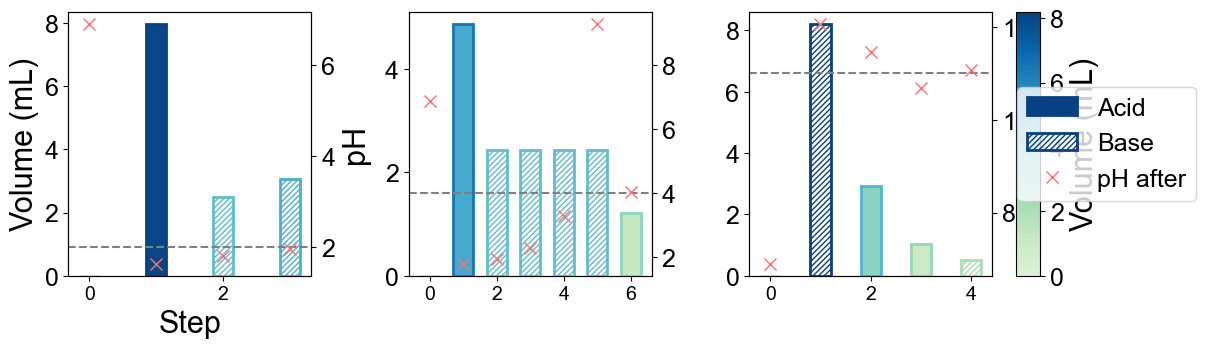

In [22]:
from __future__ import annotations
import os
from typing import List, Sequence, Union, Optional, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle, Patch
from matplotlib.lines import Line2D


def _read_file(path: str) -> pd.DataFrame:
    if path.lower().endswith(".csv"):
        df = pd.read_csv(path)
    elif path.lower().endswith((".xls", ".xlsx")):
        df = pd.read_excel(path)
    else:
        raise ValueError(f"Unsupported file extension: {path!r}")
    if "step" not in df.columns or df["step"].isnull().any():
        df.insert(0, "step", np.arange(1, len(df) + 1, dtype=int))
    df["step"] = df["step"].astype(int)
    step0 = dict(
        step=0,
        reagent="none",
        volume=0.0,
        pH_before=df.loc[0, "pH_before"],
        pH_after=df.loc[0, "pH_before"],
        pH_change=0.0,
    )
    return pd.concat([pd.DataFrame([step0]), df], ignore_index=True)


def plot_ph_files(
    files: List[str],
    target_pH: Union[float, Sequence[float]] = 7.0,
    nrows: int = 1,
    ncols: Optional[int] = None,
    figsize_per_subplot: Tuple[float, float] = (4.0, 3.0),
    font_size_label: float = 22,
    font_size_tick: float = 18,
    font_size_xtick: float = 14,
    margins: Tuple[float, float, float, float] = (0.08, 0.15, 0.06, 0.94),  # (left, legend_width, bottom, top)
    wspace: float = 0.4,
    hspace: float = 0.5,
    save_path: Optional[str] = None,
    filename: str = "ph_multi.svg",
) -> None:
    """
    绘制多图时恢复默认纵横比例（按照 figsize_per_subplot 给定的宽高）。
    """
    # 1. 读取和准备
    dfs = [_read_file(f) for f in files]
    nplots = len(dfs)
    if isinstance(target_pH, (list, tuple, np.ndarray)):
        if len(target_pH) != nplots:
            raise ValueError("target_pH 长度必须与 files 一致")
        tp_list = list(map(float, target_pH))
    else:
        tp_list = [float(target_pH)] * nplots

    # 2. 配色 & 归一化
    cmap_orig = cm.get_cmap("GnBu")
    custom_cmap = LinearSegmentedColormap.from_list(
        "custom_GnBu", cmap_orig(np.linspace(0.15, 1, 256))
    )
    all_vols = pd.concat([df["volume"] for df in dfs])
    vol_norm = mcolors.Normalize(vmin=all_vols.min(), vmax=all_vols.max())

    # 3. 子图行列
    if ncols is None:
        ncols = int(np.ceil(nplots / nrows))

    # 4. Figure 大小：直接用每子图宽高乘以行列数
    fig_w = figsize_per_subplot[0] * ncols
    fig_h = figsize_per_subplot[1] * nrows

    left, legend_w, bottom, top = margins
    right = 1 - legend_w
    fig, axes = plt.subplots(nrows, ncols,
                             figsize=(fig_w, fig_h),
                             squeeze=False)
    axes_flat = axes.flatten()

    # 5. 预计算柱宽
    bars_counts = [(df["reagent"] != "none").sum() for df in dfs]
    max_bars = max(bars_counts) if bars_counts else 1
    width_max = 0.6

    # 6. 绘图循环
    for idx, (df, path) in enumerate(zip(dfs, files)):
        ax = axes_flat[idx]
        steps = df["step"]
        volumes = df["volume"]
        pH_after = df["pH_after"]
        reagents = df["reagent"]

        # 动态柱宽
        cnt = bars_counts[idx]
        width = width_max * (cnt / max_bars) if max_bars > 0 else width_max

        # 柱状图
        for st, vol, reagent in zip(steps, volumes, reagents):
            face = custom_cmap(vol_norm(vol)) if reagent != "none" else (0.8, 0.8, 0.8, 1)
            edge = custom_cmap(min(vol_norm(vol) + 0.2, 1.0))
            if reagent == "acid":
                ax.bar(st, vol, width=width,
                       color=face, edgecolor=edge, linewidth=2.0, zorder=3)
            else:
                hatch = "//////" if reagent == "base" else None
                ax.add_patch(Rectangle((st-width/2, 0), width, vol,
                                       facecolor="none", edgecolor=edge,
                                       linewidth=2.0, hatch=hatch, zorder=3))
                ax.bar(st, vol, width=width,
                       color=face, edgecolor=edge, alpha=0.0)

        # pH 曲线 & 目标线
        ax2 = ax.twinx()
        ax2.plot(steps, pH_after, "x", color="#FF7070", markersize=8, zorder=4)
        ax2.axhline(tp_list[idx], color="gray", ls="--", lw=1.5, zorder=2)

        # 仅第一个子图显示轴标签
        if idx == 0:
            ax.set_xlabel("Step", fontsize=font_size_label)
            ax.set_ylabel("Volume (mL)", fontsize=font_size_label)
            ax2.set_ylabel("pH", fontsize=font_size_label)
        else:
            ax.set_xlabel("")
            ax.set_ylabel("")
            ax2.set_ylabel("")

        # 刻度 & 范围
        ax.set_ylim(bottom=0)
        evens = [st for st in steps if st % 2 == 0]
        ax.set_xticks(evens)
        ax.tick_params(axis='x', labelsize=font_size_xtick)
        ax.tick_params(axis='y', labelsize=font_size_tick)
        ax2.tick_params(labelsize=font_size_tick)
        ax.grid(False)
        ax2.grid(False)

    # 隐藏多余子图
    for j in range(nplots, len(axes_flat)):
        axes_flat[j].axis("off")

    # 7. colorbar
    sm = cm.ScalarMappable(norm=vol_norm, cmap=custom_cmap)
    sm.set_array([])
    cax = fig.add_axes([right + 0.02, bottom, 0.02, top - bottom])
    cbar = fig.colorbar(sm, cax=cax, orientation="vertical", label="Volume (mL)")
    cbar.ax.tick_params(labelsize=font_size_tick)
    cbar.ax.yaxis.label.set_size(font_size_label)

    # 8. 图例
    leg_ax = fig.add_axes([right + 0.06, bottom, legend_w - 0.08, top - bottom])
    leg_ax.axis("off")
    deep_col = custom_cmap(1.0)
    legend_elems = [
        Patch(facecolor=deep_col, edgecolor=deep_col, label="Acid", linewidth=2.0),
        Patch(facecolor="none", edgecolor=deep_col, hatch="//////", label="Base", linewidth=2.0),
        Line2D([0], [0], marker="x", ls="None", markeredgecolor="#FF7070", markersize=8, label="pH after"),
    ]
    leg_ax.legend(handles=legend_elems, loc="center", fontsize=font_size_tick)

    # 9. 调整间距
    fig.subplots_adjust(left=left, right=right, bottom=bottom, top=top,
                        wspace=wspace, hspace=hspace)

    # 10. 保存/展示
    if save_path:
        os.makedirs(save_path, exist_ok=True)
        fig.savefig(os.path.join(save_path, filename), dpi=300, bbox_inches="tight")
        print(f"Saved: {os.path.join(save_path, filename)}")
    else:
        plt.show()


# --------------------------- 使用示例 ----------------------------
if __name__ == "__main__":
    files = [
        r"C:\Users\ZSY\Desktop\code\ph\写文章\数据\蛋白粉\蛋白粉1.xlsx",
        r"C:\Users\ZSY\Desktop\code\ph\写文章\数据\蛋白粉\蛋白粉2.xlsx",
        r"C:\Users\ZSY\Desktop\code\ph\写文章\数据\蛋白粉\蛋白粉3.xlsx",
    ]
    target_pH = [2, 4, 11]
    plot_ph_files(
        files,
        target_pH=target_pH,
        nrows=1,
        ncols=3,
        figsize_per_subplot=(4.0, 3.0),
        font_size_label=22,
        font_size_tick=18,
        font_size_xtick=14,
        margins=(0.08, 0.15, 0.06, 0.94),
        wspace=0.4,
        hspace=0.5,
        save_path=r"C:\Users\ZSY\Desktop\画图3\整理",
        filename="蛋白粉调pH.svg"
    )


C:\Users\ZSY\AppData\Local\Temp\ipykernel_42748\3077468995.py:65: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_orig = cm.get_cmap("GnBu")


Saved: C:\Users\ZSY\Desktop\画图3\整理\SSA调pH.svg


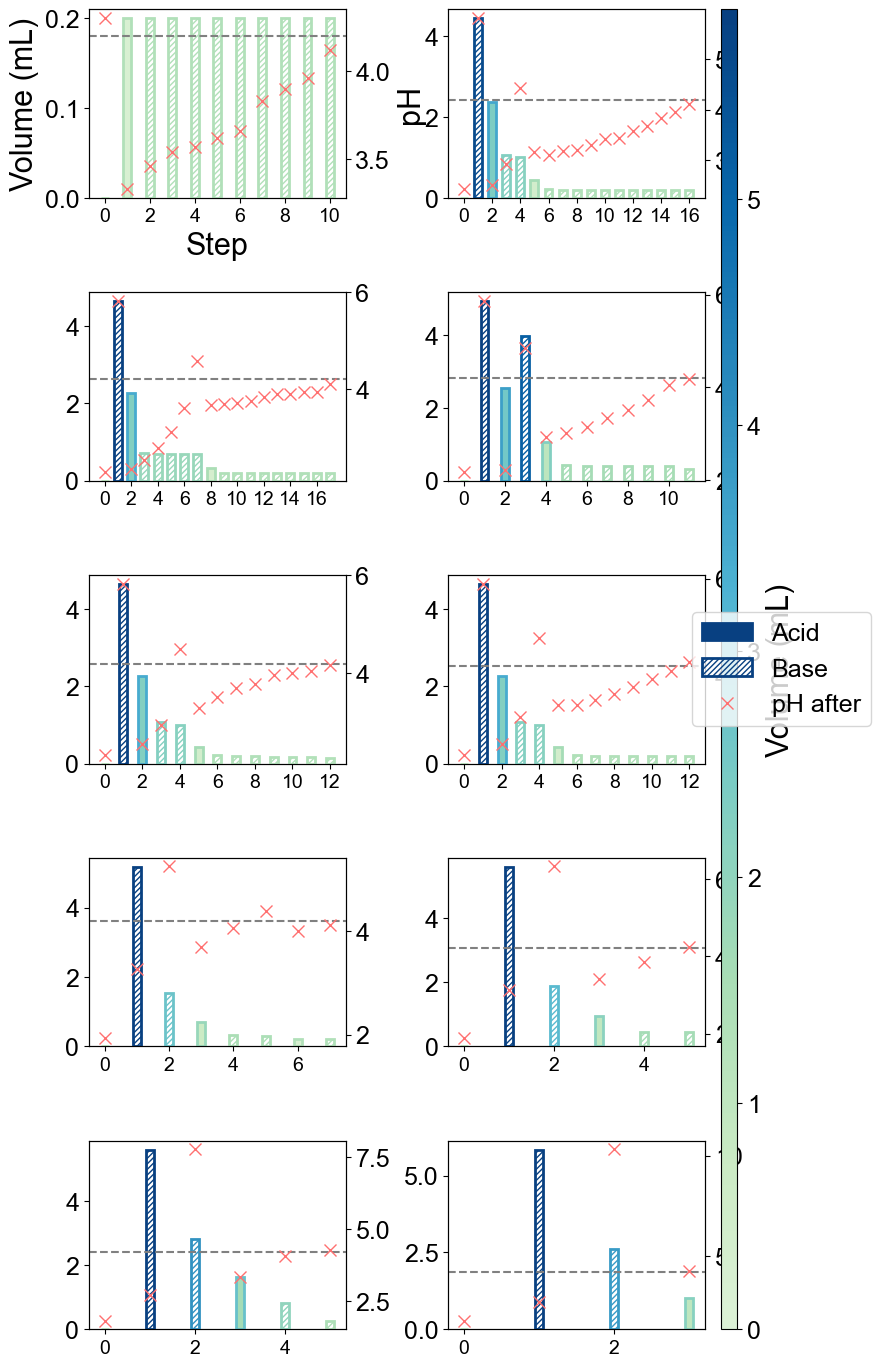

In [32]:



# --------------------------- 使用示例 ----------------------------
if __name__ == "__main__":
    files = [r"C:\Users\ZSY\Desktop\code\ph\写文章\数据\SSA\实验日志1r.csv",
              r"C:\Users\ZSY\Desktop\code\ph\写文章\数据\SSA\实验日志2-R.csv", 
              r"C:\Users\ZSY\Desktop\code\ph\写文章\数据\SSA\实验日志3-R.csv", 
              r"C:\Users\ZSY\Desktop\code\ph\写文章\数据\SSA\实验日志4-R'.csv",
              r"C:\Users\ZSY\Desktop\code\ph\写文章\数据\SSA\实验日志5.csv",
                   r"C:\Users\ZSY\Desktop\code\ph\写文章\数据\SSA\实验日志6-R.csv",
                   r"C:\Users\ZSY\Desktop\code\ph\写文章\数据\SSA\实验日志7r.csv",
                     r"C:\Users\ZSY\Desktop\code\ph\写文章\数据\SSA\实验日志8r.csv",
                     r"C:\Users\ZSY\Desktop\code\ph\写文章\数据\SSA\实验日志9-R.csv",
                     r"C:\Users\ZSY\Desktop\code\ph\写文章\数据\SSA\实验日志10-R.csv",
            ]
    target_pH = [4.2] * len(files)
    plot_ph_files(
        files,
        target_pH=target_pH,
        nrows=5,
        ncols=2,
        figsize_per_subplot=(4.0, 3.0),
        font_size_label=22,
        font_size_tick=18,
        font_size_xtick=14,     # ← 指定横轴刻度更小
        margins=(0.08, 0.15, 0.06, 0.94),
        wspace=0.4,
        hspace=0.5,
        save_path=r"C:\Users\ZSY\Desktop\画图3\整理",
        filename="SSA调pH.svg"
    )

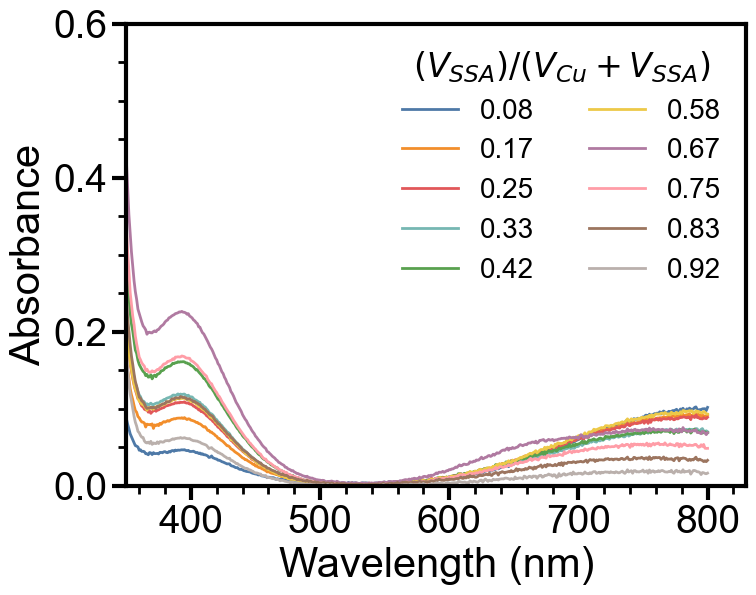

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

# ————————— 设置字体 & 样式 —————————
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.unicode_minus'] = False  # 负号正常显示
plt.rcParams['font.size'] = 24              # 全局字体大小
plt.rcParams['lines.linewidth'] = 2.0       # 全局线宽

# ————————— 配色方案 (ColorBrewer “Paired” 色板) —————————
colors = [
    "#4E79A7", "#F28E2B", "#E15759", "#76B7B2", "#59A14F",
    "#EDC948", "#B07AA1", "#FF9DA7", "#9C755F", "#BAB0AC"
]

# ————————— 图例标签映射 —————————
legend_labels = {
    1: '0.08',
    2: '0.17',
    3: '0.25',
    4: '0.33',
    5: '0.42',
    6: '0.58',
    7: '0.67',
    8: '0.75',
    9: '0.83',
    10: '0.92'
}

# ————————— 读取数据 —————————
df = pd.read_excel(
    r'C:\Users\ZSY\Desktop\code\ph\写文章\uv.xlsx',
    header=1
)

# 定义样本组
groups = [
    [1,2,3,4,5,6,7,8,9,10],
]

# ————————— 分组作图 —————————
for i, group in enumerate(groups):
    fig, ax = plt.subplots(figsize=(8, 6))  # 固定图形大小为 8x6 英寸

    for sample in group:
        idx = sample - 1                # 0-based index
        wl_col = df.columns[2*idx]      # 波长列
        ab_col = df.columns[2*idx + 1]  # 吸光度列

        # 提取并排序
        sub = df[[wl_col, ab_col]].dropna().sort_values(by=wl_col)
        ax.plot(
            sub[wl_col],
            sub[ab_col],
            label=legend_labels[sample],
            color=colors[idx % len(colors)],
            linewidth=2
        )

    # 坐标轴 & 标题
    ax.set_xlim(350, None)
    ax.set_ylim(0, 0.6)
    ax.set_xlabel('Wavelength (nm)', fontsize=30, fontname='Arial')
    ax.set_ylabel('Absorbance', fontsize=30, fontname='Arial')

    # 次/主刻度 & 边框
    ax.minorticks_on()
    ax.tick_params(
        which='major', direction='out',
        length=10, width=3, labelsize=28
    )
    ax.tick_params(
        which='minor', direction='out',
        length=6, width=2
    )
    for spine in ax.spines.values():
        spine.set_linewidth(3)

    # 图例
    legend = ax.legend(
        ncol=2,
        frameon=False,
        prop={'family': 'Arial', 'size': 20},
        loc='best',
        title=r'$(V_{SSA})/(V_{Cu}+V_{SSA})$',
        title_fontproperties={'family': 'Arial', 'size': 24}
    )
    for text in legend.get_texts():
        text.set_fontsize(20)
        text.set_fontfamily('Arial')

    # 保存为 SVG 矢量图
    plt.savefig(r'C:\Users\ZSY\Desktop\画图3\整理\SSA-uv.svg', format='svg', bbox_inches='tight')
    plt.show()


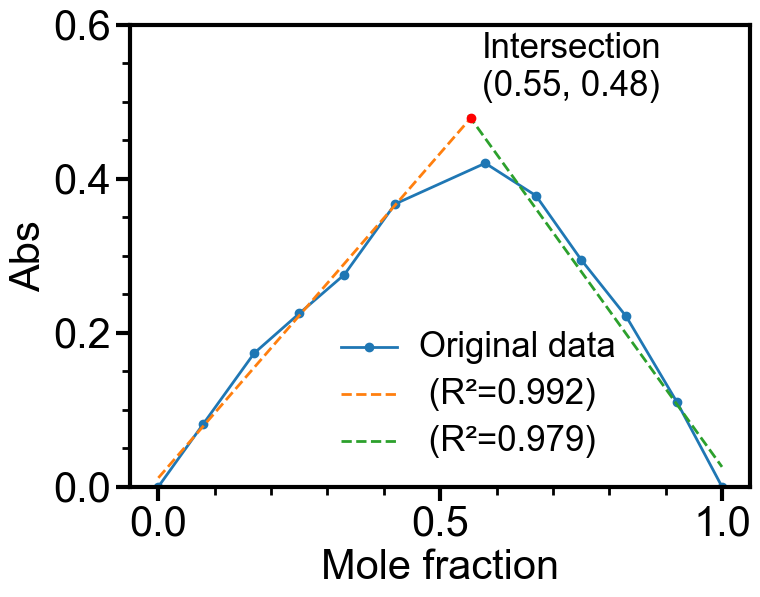

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# ————————— 设置字体 & 样式 —————————
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.size'] = 24

# 1. 原始数据
x = np.array([0, 0.08, 0.17, 0.25, 0.33, 0.42, 0.58, 0.67, 0.75, 0.83, 0.92, 1])
y = np.array([
    0,
    0.081843741,
    0.173371182,
    0.224972263,
    0.275422785,
    0.367145936,
    0.420144885,
    0.377897808,
    0.294859575,
    0.221151796,
    0.109950085,
    0
])

# 2. 分段数据
x1, y1 = x[:6], y[:6]    # 前 6 个点
x2, y2 = x[-6:], y[-6:]  # 后 6 个点

# 3. 线性拟合
coef1 = np.polyfit(x1, y1, 1)   # [k1, b1]
coef2 = np.polyfit(x2, y2, 1)   # [k2, b2]
fit1 = np.poly1d(coef1)
fit2 = np.poly1d(coef2)

# 4. 计算 R²
def r2_score(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - ss_res / ss_tot

r2_1 = r2_score(y1, fit1(x1))
r2_2 = r2_score(y2, fit2(x2))

# 5. 计算交点
k1, b1 = coef1
k2, b2 = coef2
x_int = (b2 - b1) / (k1 - k2)
y_int = fit1(x_int)

# 6. 绘图
fig, ax = plt.subplots(figsize=(8, 6))

# 绘制原始数据
ax.plot(x, y, 'o-', label='Original data', linewidth=2)

# 绘制分段线性拟合
x_fit1 = np.linspace(0.0, 0.55, 100)
x_fit2 = np.linspace(0.55, 1.0, 100)
ax.plot(x_fit1, fit1(x_fit1), '--', label=f' (R²={r2_1:.3f})', linewidth=2)
ax.plot(x_fit2, fit2(x_fit2), '--', label=f' (R²={r2_2:.3f})', linewidth=2)

# 标记并注释交点
ax.scatter([x_int], [y_int], color='red', zorder=5)
ax.text(
    x_int + 0.02, y_int + 0.02,
    f'Intersection\n({x_int:.2f}, {y_int:.2f})',
    fontsize=25,
    fontname='Arial',
    va='bottom',
    ha='left'
)

# 轴标签
ax.set_xlabel('Mole fraction', fontsize=30, fontname='Arial')
ax.set_ylabel('Abs', fontsize=30, fontname='Arial')

# 设置 y 轴范围
ax.set_ylim(0, 0.6)

# 主刻度和次刻度向外
ax.minorticks_on()
ax.tick_params(which='major', direction='out', length=10, width=3, labelsize=30)
ax.tick_params(which='minor', direction='out', length=6, width=2)

# 设置粗边框
for spine in ax.spines.values():
    spine.set_linewidth(3)

# 图例
legend = ax.legend(
    prop={'family': 'Arial', 'size': 20},
    frameon=False,
    loc='center left',
    bbox_to_anchor=(0.3, 0.2),
    handlelength=2,
    handletextpad=0.8
)
for text in legend.get_texts():
    text.set_fontsize(25)
    text.set_fontfamily('Arial')

# 保存为矢量格式 SVG
plt.savefig(r'C:\Users\ZSY\Desktop\画图3\整理\jobs_plot.svg', format='svg', bbox_inches='tight')
plt.show()


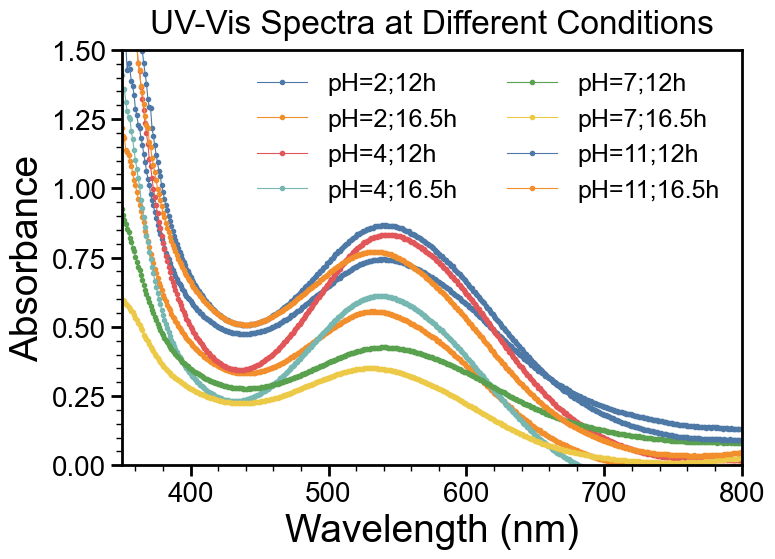

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# ————————— 设置字体和全局样式 —————————
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial']
mpl.rcParams['axes.unicode_minus'] = False
mpl.rcParams['font.size'] = 20
mpl.rcParams['lines.linewidth'] = 0.5   # 全局线宽设细

# ————————— 定义配色方案 —————————
colors = [
    "#4E79A7",  # 深蓝
    "#F28E2B",  # 橙
    "#E15759",  # 红
    "#76B7B2",  # 浅蓝绿
    "#59A14F",  # 绿
    "#EDC948",  # 黄
]

# ————————— 读取数据 —————————
file_path = r"C:\Users\ZSY\Desktop\code\ph\写文章\数据\蛋白粉\UVall.xlsx"
df = pd.read_excel(file_path, sheet_name='Sheet1')

# 提取波长和不同条件列名
wavelengths = pd.to_numeric(df.iloc[:, 0], errors='coerce')
conditions = df.columns[1:]

# 将所有吸光度列转换为数值
for cond in conditions:
    df[cond] = pd.to_numeric(df[cond], errors='coerce')

# ————————— 绘图 —————————
fig, ax = plt.subplots(figsize=(8, 6))

for i, cond in enumerate(conditions):
    absorbances = df[cond].values
    valid = (~np.isnan(wavelengths)) & (~np.isnan(absorbances))
    c = colors[i % len(colors)]
    ax.plot(
        wavelengths[valid],
        absorbances[valid],
        label=cond,
        color=c,
        linewidth=0.8,        # 细一些的线
        marker='o',
        markersize=3,         # 小一点的点
        markerfacecolor=c,    
        markeredgecolor=c     
    )

# ————————— 坐标轴设置 —————————
ax.set_xlim(350, 800)
ax.set_ylim(0, 1.5)
ax.set_xlabel('Wavelength (nm)', fontsize=28, fontname='Arial')
ax.set_ylabel('Absorbance', fontsize=28, fontname='Arial')
ax.set_title('UV-Vis Spectra at Different Conditions',
             fontsize=24, fontname='Arial', pad=12)

# 主/次刻度向外
ax.minorticks_on()
ax.tick_params(which='major', direction='out', length=8, width=2, labelsize=20)
ax.tick_params(which='minor', direction='out', length=4, width=1)

# 边框加粗
for spine in ax.spines.values():
    spine.set_linewidth(2)

# ————————— 图例 —————————
leg = ax.legend(
    ncol=2,
    frameon=False,
    prop={'family': 'Arial', 'size': 18},
    loc='upper right'
)
for text in leg.get_texts():
    text.set_fontfamily('Arial')
    text.set_fontsize(18)

# ————————— 保存 & 展示 —————————
plt.tight_layout()
plt.savefig(r'C:\Users\ZSY\Desktop\画图3\整理\蛋白粉_uv_vis_spectra.svg', format='svg', bbox_inches='tight')
plt.show()


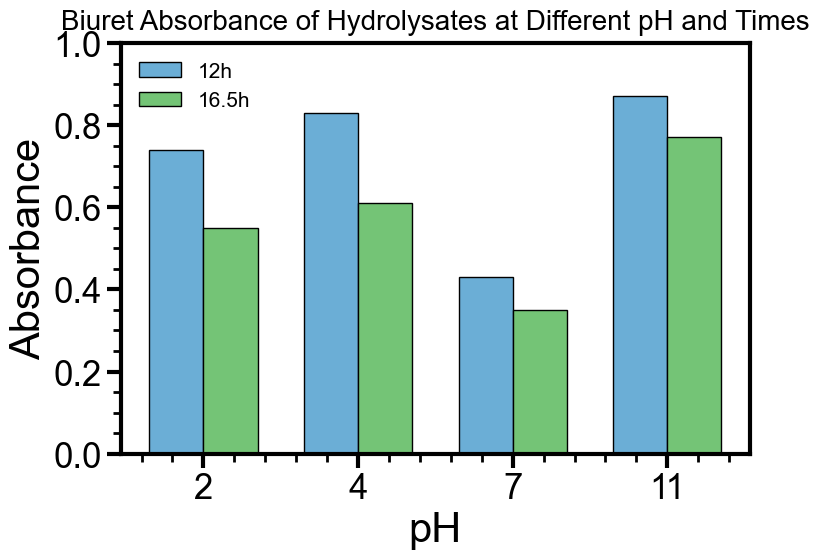

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

# —————— 设置字体和全局样式 ——————
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial']
mpl.rcParams['axes.unicode_minus'] = False
mpl.rcParams['font.size'] = 20
mpl.rcParams['lines.linewidth'] = 0.5

# —————— 创建数据 ——————
data = {
    'pH': [2, 4, 7, 11],
    'Absorbance(12h)': [0.74, 0.83, 0.43, 0.87],
    'Absorbance(16.5h)': [0.55, 0.61, 0.35, 0.77]
}
df = pd.DataFrame(data)

# —————— 配色：柔和蓝绿色系 ——————
colors = ["#6BAED6", "#74C476"]  # 浅蓝，浅绿

# —————— 绘图 ——————
fig, ax = plt.subplots(figsize=(8, 6))

bar_width = 0.35
x = np.arange(len(df['pH']))

bars1 = ax.bar(
    x - bar_width/2,
    df['Absorbance(12h)'],
    bar_width,
    label='12h',
    color=colors[0],
    edgecolor='black',
    linewidth=1
)
bars2 = ax.bar(
    x + bar_width/2,
    df['Absorbance(16.5h)'],
    bar_width,
    label='16.5h',
    color=colors[1],
    edgecolor='black',
    linewidth=1
)

# —————— 轴标签 & 标题 ——————
ax.set_xlabel('pH', fontsize=30, fontname='Arial')
ax.set_ylabel('Absorbance', fontsize=30, fontname='Arial')
ax.set_title(
    'Biuret Absorbance of Hydrolysates at Different pH and Times',
    fontsize=20,
    fontname='Arial',
    pad=10
)

# —————— X 轴刻度 ——————
ax.set_xticks(x)
ax.set_xticklabels(df['pH'], fontsize=25, fontname='Arial')

# —————— Y 轴范围 ——————
ax.set_ylim(0, 1.0)

# —————— 图例 ——————
ax.legend(
    ncol=1,
    frameon=False,
    prop={'family': 'Arial', 'size': 15},
    loc='best'
)

# —————— 刻度 样式 ——————
ax.minorticks_on()
ax.tick_params(
    which='major',
    direction='out',
    length=10,
    width=3,
    labelsize=25
)
ax.tick_params(
    which='minor',
    direction='out',
    length=6,
    width=2
)

# —————— 边框加粗 ——————
for spine in ax.spines.values():
    spine.set_linewidth(3)

# —————— 保存 & 展示 ——————
plt.tight_layout()
plt.savefig(r'C:\Users\ZSY\Desktop\画图3\整理\biuret_absorbance.svg', format='svg', bbox_inches='tight')
plt.show()


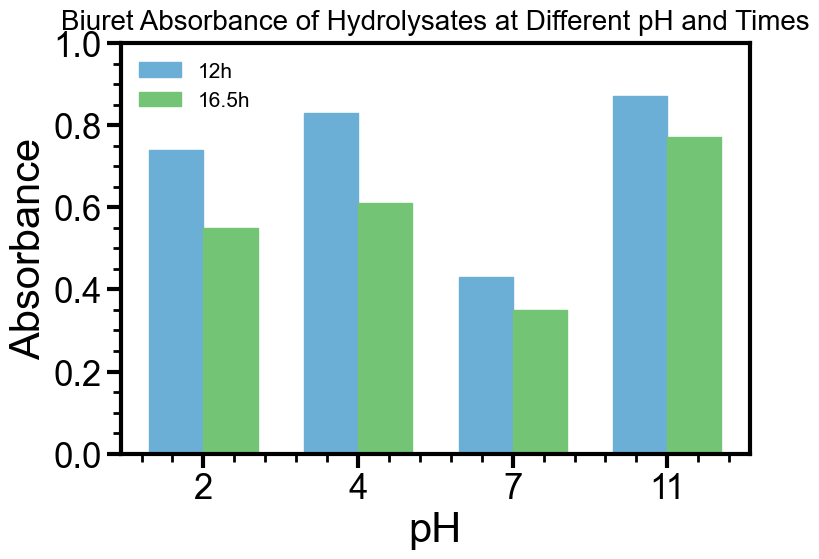

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

# —————— 设置字体和全局样式 ——————
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial']
mpl.rcParams['axes.unicode_minus'] = False
mpl.rcParams['font.size'] = 20
mpl.rcParams['lines.linewidth'] = 0.5

# —————— 创建数据 ——————
data = {
    'pH': [2, 4, 7, 11],
    'Absorbance(12h)': [0.74, 0.83, 0.43, 0.87],
    'Absorbance(16.5h)': [0.55, 0.61, 0.35, 0.77]
}
df = pd.DataFrame(data)

# —————— 配色：柔和蓝绿色系 ——————
colors = ["#6BAED6", "#74C476"]  # 浅蓝，浅绿

# —————— 绘图 ——————
fig, ax = plt.subplots(figsize=(8, 6))

bar_width = 0.35
x = np.arange(len(df['pH']))

bars1 = ax.bar(
    x - bar_width/2,
    df['Absorbance(12h)'],
    bar_width,
    label='12h',
    color=colors[0],
    edgecolor=colors[0],  # 边框同内部颜色
    linewidth=1
)
bars2 = ax.bar(
    x + bar_width/2,
    df['Absorbance(16.5h)'],
    bar_width,
    label='16.5h',
    color=colors[1],
    edgecolor=colors[1],  # 边框同内部颜色
    linewidth=1
)

# —————— 轴标签 & 标题 ——————
ax.set_xlabel('pH', fontsize=30, fontname='Arial')
ax.set_ylabel('Absorbance', fontsize=30, fontname='Arial')
ax.set_title(
    'Biuret Absorbance of Hydrolysates at Different pH and Times',
    fontsize=20,
    fontname='Arial',
    pad=10
)

# —————— X 轴刻度 ——————
ax.set_xticks(x)
ax.set_xticklabels(df['pH'], fontsize=25, fontname='Arial')

# —————— Y 轴范围 ——————
ax.set_ylim(0, 1.0)

# —————— 图例 ——————
ax.legend(
    ncol=1,
    frameon=False,
    prop={'family': 'Arial', 'size': 15},
    loc='best'
)

# —————— 刻度 样式 ——————
ax.minorticks_on()
ax.tick_params(
    which='major',
    direction='out',
    length=10,
    width=3,
    labelsize=25
)
ax.tick_params(
    which='minor',
    direction='out',
    length=6,
    width=2
)

# —————— 边框加粗 ——————
for spine in ax.spines.values():
    spine.set_linewidth(3)

# —————— 保存 & 展示 ——————
plt.tight_layout()
plt.savefig(r'C:\Users\ZSY\Desktop\画图3\整理\biuret_absorbance.svg', format='svg', bbox_inches='tight')
plt.show()


In [2]:
import matplotlib.pyplot as plt
import numpy as np

def plot_and_save(success, overshoot, avg_steps, models,
                  font_size=12, filename='model_comparison.svg'):
    """
    绘制双纵轴柱状图并保存为矢量图。
    
    参数:
    - success: list of float, Success Rate (%)
    - overshoot: list of float, Overshoot Incidence (%)
    - avg_steps: list of float, Average Steps
    - models: list of str, 模型名称
    - font_size: int, 全局字体大小
    - filename: str, 输出文件名（支持 .svg, .pdf 等矢量格式）
    """
    # 配置字体
    plt.rcParams['font.size'] = font_size
    plt.rcParams['font.family'] = 'Arial'
    
    # 坐标与宽度
    x = np.arange(len(models))
    width = 0.25
    colors = ['#2ca02c', '#1f77b4', '#17becf']
    
    # 创建图表
    fig, ax1 = plt.subplots(figsize=(8, 6))
    ax2 = ax1.twinx()
    
    # 绘制柱状图
    bars1 = ax1.bar(x - width, success, width,
                    label='Success Rate (%)',
                    color=colors[0], edgecolor=colors[0], linewidth=1.5)
    bars2 = ax1.bar(x, overshoot, width,
                    label='Overshoot Incidence (%)',
                    color=colors[1], edgecolor=colors[1], linewidth=1.5)
    bars3 = ax2.bar(x + width, avg_steps, width,
                    label='Avg Steps',
                    color=colors[2], edgecolor=colors[2], linewidth=1.5)
    
    # 坐标轴标签与刻度
    ax1.set_xlabel('Model')
    ax1.set_ylabel('Percentage (%)')
    ax2.set_ylabel('Average Steps')
    ax1.set_xticks(x)
    ax1.set_xticklabels(models, rotation=15, ha='right')
    
    # 移除网格线
    ax1.grid(False)
    ax2.grid(False)
    
    # 合并图例
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1 + h2, l1 + l2, loc='upper left')
    
    plt.title('Model Comparison Across Three Metrics')
    plt.tight_layout()
    
    # 保存矢量图
    fig.savefig(filename, format=filename.split('.')[-1])
    plt.close(fig)
    print(f"Saved vector chart to {filename}")

# 示例调用
if __name__ == '__main__':
    models = ['Bayesian Rule-Based', 'Imitation Learning', 'Reinforcement Learning']
    success = [94.23, 93.77, 94.27]
    overshoot = [41.84, 34.41, 30.55]
    avg_steps = [12.73, 10.22, 10.21]
    # 调用时可以调整 font_size 和 filename
    plot_and_save(success, overshoot, avg_steps, models,
                  font_size=18, filename='model_comparison.svg')
    plt.show()  # 如果需要在脚本中直接展示图形

Saved vector chart to model_comparison.svg
